# Introduction

My goal for this project is to predict the price of an Airbnb listing in Amsterdam. I will be using [this dataset](http://insideairbnb.com/get-the-data.html) to do so. 

I have also taken some inspiration from [this other notebook](https://nbviewer.jupyter.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb#Categorical-features) to help me with this project.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import descartes
import geopandas as gpd
import time
import pickle
import os.path
import lightgbm as lgb

from os import path
from shapely.geometry import Point, Polygon
from scipy import stats
from scipy.stats import norm
from datetime import datetime, date
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Looking at the Data

In [2]:
df = pd.read_csv('data/listings.csv')
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190808195507,2019-08-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.12
1,20168,https://www.airbnb.com/rooms/20168,20190808195507,2019-08-09,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.46
2,25428,https://www.airbnb.com/rooms/25428,20190808195507,2019-08-09,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.16


In [3]:
print('There are', df.shape[0], 'observations and', df.shape[1], 'variables.')

There are 20677 observations and 106 variables.


As we can see, there are numerous variables in this dataset. Some are more useful than others. It would be helpful to understand briefly what these variables are, and though some are self-explanatory, others are not. Below I list some of the variables I had trouble understanding and their meaning after some research:

__Descriptions of some unclear variables__

| __Variable Name__ 	| __Description__ 	|
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| `space` 	| A more detailed description of the property.  	|
| `experienced_offered` 	| Unclear what this means (perhaps related to [Airbnb Experiences](https://blog.atairbnb.com/what-are-airbnb-experiences/)?), but all of the properties have this variable as `none`, so it is safe to drop this column completely since it will not help our model. 	|
| `access` 	| Textual description of how much space is accessible by the guest. Some are missing. 	|
| `interaction` 	| How the guest can interact with the host. 	|
| `neighbourhood_cleansed`, `neighbourhood_group_cleansed` 	| A variable that was further processed from the `neighbourhood` column. All values for `neighbourhood_group_cleansed` are missing, so it would be safe to drop it. 	|
| `market` and `smart_location` 	| Location of these listings. Given the inconsistency of `smart_location`, I will drop it in favor of `neighbourhood_cleansed`. 	|
| `minimum_minimum_nights`, `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights` 	| Refers to the maximum or minimum amount of nights that a property has had in terms of their `minimum_nights` and `maximum_nights`. For simplicity, these columns will be dropped. 	|
| `availability_30`, `availability_60`, `availability_90`, `availability_365` 	| The number of days that the property can be rented within the next 30, 60, 90 and 365 days. As if Jan. 1st, 2019, [Airbnb regulations in Amsterdam state that properties can only be rented out for 30 days](https://www.airbnb.com/help/article/860/amsterdam). So, I will only use `availability_30`. 	|
| `number_of_reviews_ltm` 	| The number of reviews in the last twelve months (ltm). `number_of_reviews` will be used instead.	|
| `calculated_host_listings_count`, `calculated_host_listings_count_entire_homes`, `calculated_host_listings_count_private_rooms`, `calculated_host_listings_count_shared_rooms` 	| The calculated number of listings this particular host has, split into different types of properties. For simplicity, I will just use `calculated_host_listings_count` and drop the rest. 	|

Now that I have some general understanding of the variables in this dataset, it is time to make some educated guesses as to what variables could greatly influence `price`. 

Off the top of my head, here are some factors that I expect to be greatly influence the `price` of a listing:

| __Variable Name__ 	| __Why I Think It's Influential__ 	|
|--------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| `host_is_superhost` 	| If a host performs superbly, then that host can become a Superhost. Given this status boost, they may price their properties more.  	|
| `neighbourhood_cleansed` 	| Like in real-estate, location is a huge factor in determining the price of a listing. I chose using this cleansed version since it seems to have already been preprocessed from `neighbourhood` by Inside Airbnb. 	|
| `amenities` 	| The number of amenities as well as what those amenities are could be a big factor in terms of pricing a listing on Airbnb. More amenities available to the guest would mean that that guest would have to pay more. 	|
| `square_feet` 	| It makes sense to think that the size of the property would influence price. 	|
| `review_scores_rating` 	| The overall rating of the listing could influence price. 	|


Before going into the missing data, it would help to lessen the amount of variables I have to analyze. There are two cases I will consider: whether or not a variable repeats the same value for each observation in the dataset, whether or not variable is inherently useful in predicting the price.

For the first case, there could be several variables that have the same value for each property. It could very well be the case that since this dataset is for Amsterdam listings only, all properties will have `Netherlands` for the `country` variable. I will delete such variables since they provide no additional information to price. 

For the second case, it is important to consider that there are variables that will not be helpful in predicting the price, such as the URL of the listing `listing_url` and the ID of discerning when the data was scraped `scrape_id`. 

In [4]:
# Case 1: Which variables have only one unique value?

delete_vars = [col for col in df.columns if len(df[col].unique()) == 1]
print(delete_vars)
        
# Delete them
df_clean = df.drop(delete_vars, axis = 1)

['scrape_id', 'experiences_offered', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 'neighbourhood_group_cleansed', 'country_code', 'country', 'has_availability', 'requires_license', 'is_business_travel_ready']


In [5]:
# Case 2: What variables left are inherently not helpful in predicting price?

# Delete URLs
delete_vars = [col for col in df_clean.columns if 'url' in col]
df_clean = df_clean.drop(delete_vars, axis = 1)

# Delete IDs 
delete_vars = [col for col in df_clean.columns if 'id' in col]
df_clean = df_clean.drop(delete_vars, axis = 1)

# Delete full textual data 
full_text_columns = ['description', 'host_name', 'name', 'summary', 'space', 'neighborhood_overview', 'notes', 'house_rules', 'access', 'interaction', 'transit', 'host_about']
df_clean = df_clean.drop(full_text_columns, axis = 1)

# Delete scraping information
df_clean = df_clean.drop(['last_scraped'], axis = 1)
df_clean = df_clean.drop(['calendar_last_scraped'], axis = 1)

In [6]:
print('After initially removing some inherently useless and non-unique variables, there are now', df_clean.shape[1], 'variables left.')

After initially removing some inherently useless and non-unique variables, there are now 72 variables left.


# What's Missing?

With less variables to look at, I can now analyze the missing variables.
Let's take a look at what variables are missing.

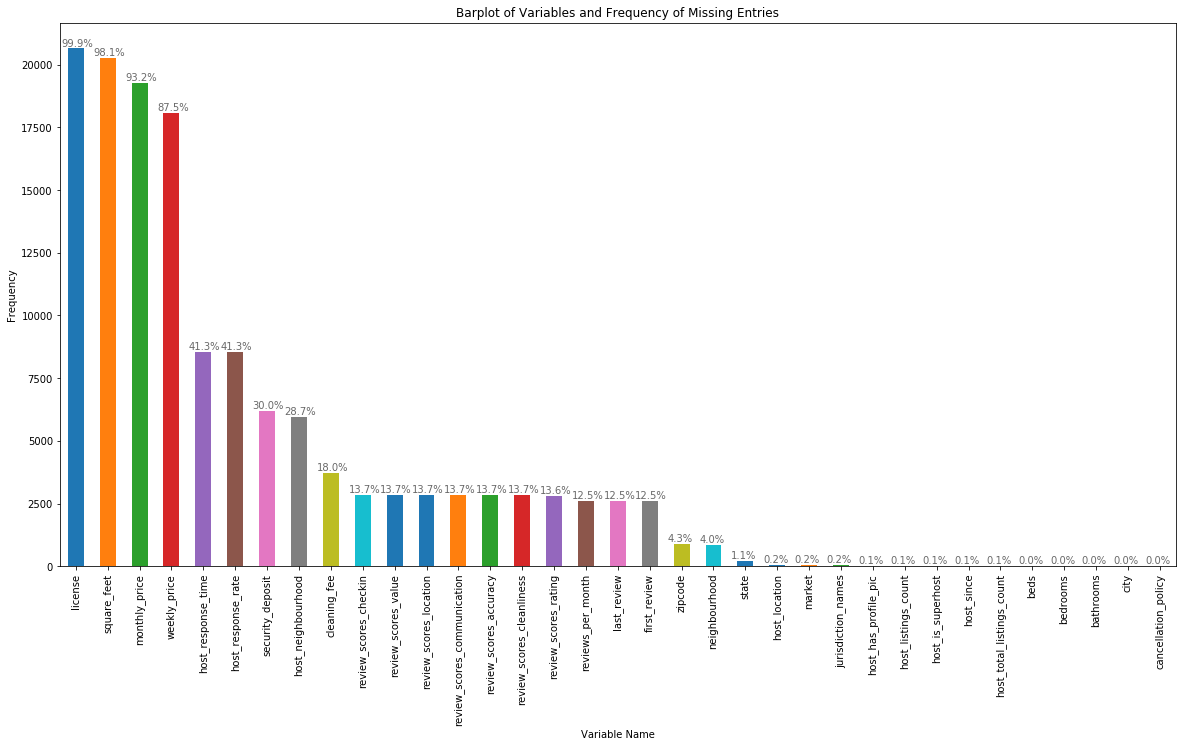

In [7]:
missing = df_clean.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending = False)

ax = missing.plot(kind='bar', figsize=(20, 10))
ax.set_alpha(0.8)
ax.set_title("Barplot of Variables and Frequency of Missing Entries")
ax.set_ylabel("Frequency")
ax.set_xlabel('Variable Name')

# Set frequency text
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x() - 0.2, i.get_height() + 100, \
            str(round((i.get_height()/len(df_clean))*100, 1))+'%', fontsize=10,
                color='dimgrey')

Let's look at these one by one, starting from the variable with the most missing entry.

- `license` corresponds to the host's license number, as some cities require this in order to list their home on Airbnb. It is also missing in about 99.9% of the dataset, and so it would seem a majority of cities do not require such a license. Given this information, I will drop this column.

In [8]:
df_clean = df_clean.drop(['license'], axis = 1)

- `square_feet` is among these variables (in fact, it is the second variable with the greatest amount of missing entries). It would seem that most properties do not list the size of that property on the Airbnb website, despite my initial expectations on how important I thought it would be. Most hosts seem to have forgotten about adding this feature. So, I will drop this column from the dataset.

In [9]:
df_clean = df_clean.drop(['square_feet'], axis = 1)

- `monthly_price` and `weekly_price` are both missing in over 85% of the data, and so I will drop them. Also, I am only interested in `price`.

In [10]:
df_clean = df_clean.drop(['monthly_price', 'weekly_price'], axis = 1)


- `host_response_time` and `host_response_rate` have the same amount missing in the data (41.3%). Is there some sort of relationship? 

In [11]:
# Are the observations missing host_response_time the same as the ones missing host_response_rate?
all(df_clean[df_clean['host_response_time'].isna()].index == df_clean[df_clean['host_response_rate'].isna()].index)

True

All observations missing `host_response_time` are the same as the ones missing `host_response_rate` ie. if there is no data for `host_response_rate`, then there would be none for `host_response_time`. Why would this happen? It could be that a host cannot respond to a guest if their property has never been used, or their property was in the process of being used at the time this data was scraped.

Given this, I will impute the missing data with its own category: `no_response`.

In [12]:
df_clean['host_response_time'] = df_clean['host_response_time'].fillna('no response')
df_clean['host_response_rate'] = df_clean['host_response_rate'].fillna('no response')

- `security_deposit` corresponds to how much the host requires as a security deposit for the property. I will interpret missing values as the host not needing a security deposit for the property ie. $0. I will also preprocess the dollar values to actual floats.

In [13]:
def dollar_str_to_int(dollar_str):
    """
    Convert dollars in a column to a float.
    """
    return float(dollar_str.replace('$', '').replace(',', ''))

In [14]:
df_clean['security_deposit'] = df_clean['security_deposit'].fillna('$0')
df_clean['security_deposit'] = df_clean['security_deposit'].apply(dollar_str_to_int)

- `host_neighbourhood` corresponds to the neighborhood that the host is from. Location is already explained by `neighbourhood_cleansed`, so I will drop this column.

In [15]:
df_clean = df_clean.drop(['host_neighbourhood'], axis = 1)

- `cleaning_fee` is how much the host charges if the host has to clean to property after the guest has finished their stay. I will treat this the same way I treated `security_deposit`.

In [16]:
df_clean['cleaning_fee'] = df_clean['cleaning_fee'].fillna('$0')
df_clean['cleaning_fee'] = df_clean['cleaning_fee'].apply(dollar_str_to_int)

- The `review_scores_x` variables have almost the same amount missing in the data. Given that these are the ratings of particular properties, it would not be appropriate to drop these columns. It would also make sense that for listed properties not used by guests, there would be no value for it. As such, I will impute these missing variables with another category: `no review`. This introduces another problem, as the original column consisted of quantitative data ie. a number to rate the property. Using `no review` would require me to change the column to use qualitative data. I will discuss this more further below. 

In [17]:
df_clean['review_scores_checkin'] = df_clean['review_scores_checkin'].fillna('no review')
df_clean['review_scores_value'] = df_clean['review_scores_value'].fillna('no review')
df_clean['review_scores_location'] = df_clean['review_scores_location'].fillna('no review')
df_clean['review_scores_communication'] = df_clean['review_scores_communication'].fillna('no review')
df_clean['review_scores_accuracy'] = df_clean['review_scores_accuracy'].fillna('no review')
df_clean['review_scores_cleanliness'] = df_clean['review_scores_cleanliness'].fillna('no review')
df_clean['review_scores_rating'] = df_clean['review_scores_rating'].fillna('no review')

- `reviews_per_month` counts the number of reviews the property had at that month. Missing values will be imputed with a 0.

In [18]:
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

- `last_review`, and `first_review` have the same amount of missing variables. Again, it would make sense that unused properties would have no reviews. Additionally, some properties might have guests that chose to not leave a review. A small amount of data is missing for these columns, about 12%, and values in these columns are dates. So, I will use the number of days from the day this data was scraped (Aug. 8th, 2019 according to `scrape_id`) to the date in `last_review` and `first_review`. Missing values will be imputed with a 0, since no review was made for that property.

In [19]:
df_clean['first_review'] = pd.to_datetime(df_clean['first_review']) # Month first 
df_clean['last_review'] = pd.to_datetime(df_clean['last_review']) 

df_clean['days_since_first_review'] = (datetime(2019, 8, 8) - df_clean['first_review']).dt.days
df_clean['days_since_last_review'] = (datetime(2019, 8, 8) - df_clean['last_review']).dt.days

df_clean['days_since_first_review'] = df_clean['days_since_first_review'].fillna(0)
df_clean['days_since_last_review'] = df_clean['days_since_last_review'].fillna(0)

- `zipcode`, `neighbourhood`, `city`, and `state` are all location variables. Since I already intend to use `neighbourhood_cleansed`, I will drop the `neighbourhood` column. `city` was given by the host, and given the inconsistency of this variable, I will drop it in favor of `neighbourhood_cleansed`. The same can be said for `state` and `zipcode`.

In [20]:
df_clean = df_clean.drop(['neighbourhood', 'zipcode', 'state', 'city'], axis = 1)

- `host_location` refers to where the host is from. For this project, I will drop it, as there is not a lot of reason to suggest that where a person is located affects the price of the property. I will also drop `jurisdiction_names`, as they seem to be inconsistent wordings of Amsterdam, NL. I will, however, keep `market`, and impute missing values with the mode.

In [21]:
df_clean = df_clean.drop(['host_location', 'jurisdiction_names'], axis = 1)
df_clean['market'] = df_clean['market'].fillna(df_clean['market'].describe()['top'])

- I think it would be interesting to explore how `host_has_profile_pic` affects how popular a particular listing is. [There has been some research into how having a picture on LinkedIn increases your chances of being noticed](https://www.linkedin.com/business/sales/blog/b2b-sales/picture-perfect--make-a-great-first-impression-with-your-linkedi) - I wonder if the same can be said for Airbnb properties. Again, I will impute missing values with the mode.

In [22]:
df_clean['host_has_profile_pic'] = df_clean['host_has_profile_pic'].fillna(df_clean['host_has_profile_pic'].describe()['top'])

- `host_total_listings_count` and `host_listings_count` both refer to the number of listings a host has. I already mentioned before that I will only be using `calculated_host_listings_count`, so I will drop these two columns.

In [23]:
df_clean = df_clean.drop(['host_total_listings_count', 'host_listings_count'], axis = 1)

- Missing values for `host_is_superhost` will be imputed with the mode.

In [24]:
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].fillna(df_clean['host_is_superhost'].describe()['top'])

- `host_since` shows when the host first listed their property on Airbnb. What would be interesting to look at would be how the experience ie. the length of time that host has been hosting their particular property is related to the price. Since these are time stamps, I will keep this for a time series analysis later on. This will be dropped later in favor of `days_as_host`, which will be computed as the number of days the person has been a host since Aug. 8, 2019.  As for the missing rows, I will delete them from the dataset, considering that it would be difficult to impute them and there are only 12 such observations.

In [25]:
df_clean['host_since'] = pd.to_datetime(df_clean['host_since']) 
df_clean['days_as_host'] = (datetime(2019, 8, 8) - df_clean['host_since']).dt.days
df_clean = df_clean.dropna(subset = ['host_since'])

- Rows that are missing the remaining variables (`bedrooms` till `cancellation_policy`) will be dropped, as they make up such a small amount of our dataset. Losing them will not affect our prediction model too much. 

In [26]:
df_clean = df_clean.dropna(subset = ['bedrooms', 'beds', 'bathrooms', 'cancellation_policy'])

In [27]:
print('Before Dealing with Missing Variables:', df.shape[0], 'observations and', df.shape[1], 'variables.')
print('After Dealing with Missing Variables:', df_clean.shape[0], 'observations and', df_clean.shape[1], 'variables.')

Before Dealing with Missing Variables: 20677 observations and 106 variables.
After Dealing with Missing Variables: 20643 observations and 62 variables.


After some cleaning, I took off approximately 0.16% from the original dataset, and so I have not lost too much information. What variables are we left with?

In [28]:
for col in df_clean.columns:
    print(col)

host_since
host_response_time
host_response_rate
host_is_superhost
host_verifications
host_has_profile_pic
street
neighbourhood_cleansed
market
smart_location
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calcul

# EDA - `Price`

Now, I will look more into `price`, and how it is distributed in this dataset.

First, since it is a string, I will convert it into a float.

In [29]:
df_clean['price'] = df['price'].apply(dollar_str_to_int)
df_clean['price'].describe()

count    20643.000000
mean       159.128324
std        162.520446
min          0.000000
25%         99.000000
50%        130.000000
75%        180.000000
max       8915.000000
Name: price, dtype: float64

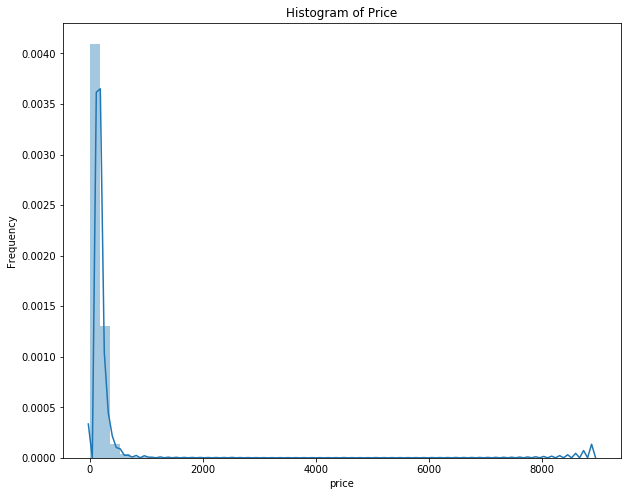

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of Price')
ax.set_ylabel('Frequency')
ax = sns.distplot(df_clean['price'])
plt.show()

In [31]:
print('Skewness:', df_clean['price'].skew())
print('Kurtosis:', df_clean['price'].kurtosis())

Skewness: 25.790751572268885
Kurtosis: 1108.9703728876766


Some things to note from this graph and the statistics:

- This is a unimodal distribution heavily skewed towards the right.
- The average price for Amsterdam Airbnb properties is \$159.
- The minimum price is \$0, which may be a mistake, and so I should investigate this observation more.
- The maximum price is \$8,915, which is crazy considering the price of other properties in the area. Properties like these may be outliers.
- The graph is heavily skewed to the right, shown by both the graph and the measure of skewness.
- Kurtosis measures the tailedness and larger values correspond to distributions with a heavier tale, such as the case here.

Given how skewed this data is, it is not appropriate to use the average price. Using the median as the measure of central tendency is better than using the mean, as the mean is pulled towards the tail of the distribution. Additionally, I will have to transform this data and make it as normal as possible, given the fact that regression models do not perform well when the data is non-normal. 

In [32]:
print('The median price of an Amsterdam Airbnb property is', df_clean['price'].median(), 'dollars.')

The median price of an Amsterdam Airbnb property is 130.0 dollars.


It is extremely apparent that `price` is not normally distributed. But, I will still test its normality to be consistent. I will do this using `scipy`.

In [33]:
def is_normal(data):
    """
    Returns True if the data given is normal ie. the p-value is less than 0.05. 
    If not, then return False.
    """

    _, p = stats.normaltest(data)
    if p < 0.05:
        return False
    else:
        return True

In [34]:
if is_normal(df_clean['price']):
    print('The data is normal.')
else:
    print('The data is NOT normal!')

The data is NOT normal!


Another way to visually represent the normality of a distribution is using a probability plot, which essentially plots how similar one distribution is to another distribution (the normal distribution, in this case).

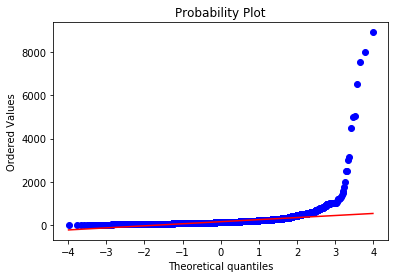

In [35]:
res = stats.probplot(df_clean['price'], plot=plt)

If `price` were normal, then the blue dots would closely follow the red line. However, there are many deviations from this line, especially at the end where there may be outliers present ie. homes that are extremely expensive. 


## A Free Amsterdam Home?
I mentioned earlier that the minimum amount for `price` is \$0. Let's look more into this.

In [36]:
# What properties are listed as having $0 in price?
df_clean[df_clean['price'] == 0]

,host_since,host_response_time,host_response_rate,host_is_superhost,host_verifications,host_has_profile_pic,street,neighbourhood_cleansed,market,smart_location,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,days_since_first_review,days_since_last_review,days_as_host
12535,2014-02-05,within an hour,100%,f,"['email', 'phone', 'reviews']",t,"Amsterdam, Noord-Holland, Netherlands",Bos en Lommer,Amsterdam,"Amsterdam, Netherlands",...,f,f,2,2,0,0,0.5,711.0,4.0,2010.0


Since only one property is missing the price, then I will drop it from my dataset.

In [37]:
df_clean = df_clean[df_clean.price != 0]

In [38]:
# What's the minimum amount now?
print('The least expensive property in this dataset is', df_clean['price'].describe()['min'], 'dollars.')

The least expensive property in this dataset is 9.0 dollars.


## Transforming `price`

Given the right-skewedness of the distribution, I will use a log-transformation to transform the data. This will be used in training the model. `price` will be kept for EDA purposes.

In [39]:
df_clean['log_price'] = np.log(df_clean['price'])

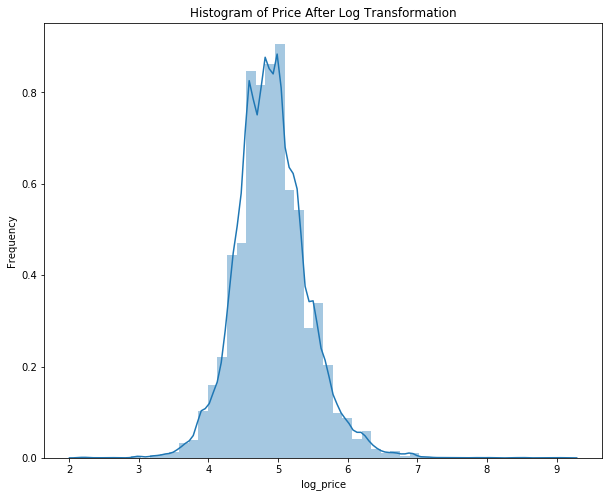

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of Price After Log Transformation')
ax.set_ylabel('Frequency')
ax = sns.distplot(df_clean['log_price'])
plt.show()

In [41]:
print('Skewness:', df_clean['log_price'].skew())
print('Kurtosis:', df_clean['log_price'].kurtosis())

Skewness: 0.5016433750312589
Kurtosis: 2.332766950843304


In [42]:
if is_normal(df_clean['log_price']):
    print('The data is normal.')
else:
    print('The data is NOT normal!')

The data is NOT normal!


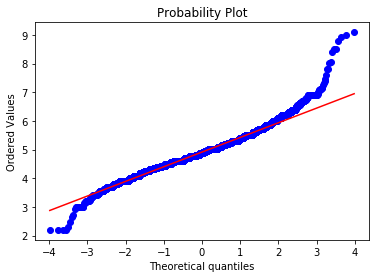

In [43]:
res = stats.probplot(df_clean['log_price'], plot=plt)

Though our normal test still claims the data is not normal, it is close enough to normality. The probability plot and histogram both show this visually.

I have also tried other types of transformations by ["going down the ladder of powers"](http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_03.pdf), but they did not perform as well as a log transformation. Below is a visualization of that. As you can see from the histograms, the data becomes more skewed the further down the ladder I go.

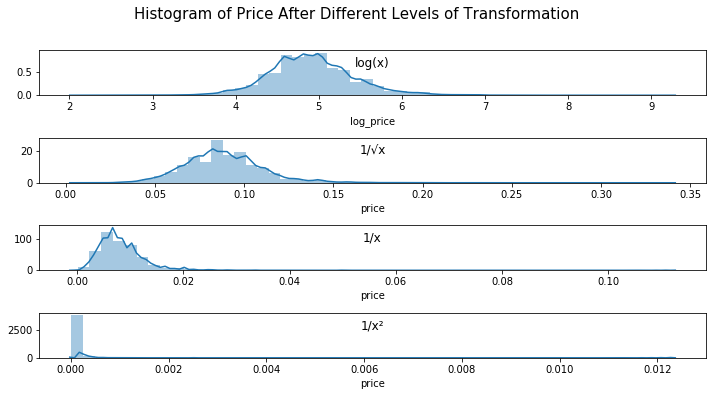

In [44]:
recip_root_price = df_clean['price'].apply(lambda x: 1 / math.sqrt(x)) # reciprocal square root = 1 / sqrt(x)
recip_price = df_clean['price'].apply(lambda x: 1 / x) # reciprocal = 1 / x
recip_sqr_price =  df_clean['price'].apply(lambda x: 1 / math.pow(x, 2)) # reciprocal squared = 1 / x^2

fig, axes = plt.subplots(figsize=(10 , 5), nrows = 4)
fig.suptitle('Histogram of Price After Different Levels of Transformation', y = 1.09, fontsize=15)

y_title_margin = 0.5
axes[0].set_title('log(x)', y = y_title_margin)
axes[1].set_title(u'1/\u221Ax', y = y_title_margin)
axes[2].set_title("1/x", y = y_title_margin)
axes[3].set_title(u"1/x\u00B2", y = y_title_margin)

sns.distplot(df_clean['log_price'], ax = axes[0])
sns.distplot(recip_root_price, ax = axes[1])
sns.distplot(recip_price, ax = axes[2])
sns.distplot(recip_sqr_price, ax = axes[3])

fig.tight_layout()

plt.show()

Note the x-axis, which is getting smaller after each transformation. This means that the data is being grouped more and more towards the left ie. smaller numbers.

# EDA - The Rest of the Independent Variables

In [45]:
print('To recap, there are', df_clean.shape[1], 'independent variables.')

To recap, there are 63 independent variables.


## Datetime Variables

In [46]:
# What are the datetime variables?
datetime_vars = [col for col in df_clean.columns if 'time' in str(df_clean[col].dtype)]

print(datetime_vars)

['host_since', 'first_review', 'last_review']


**Question:** When were people listing their properties? Why? What are the trends?

In [47]:
print('In this dataset, the first host joined on', df_clean['host_since'].describe()['first'])
print('The last host joined on', df_clean['host_since'].describe()['last'])

In this dataset, the first host joined on 2008-09-24 00:00:00
The last host joined on 2019-08-08 00:00:00


The dataset describes host joining over an 11 year timespan, from 2008 to 2019. Interestingly enough, Airbnb was founded in August of 2008, so analyzing the trend of hosts joining will show how Airbnb has grown in this timespan.

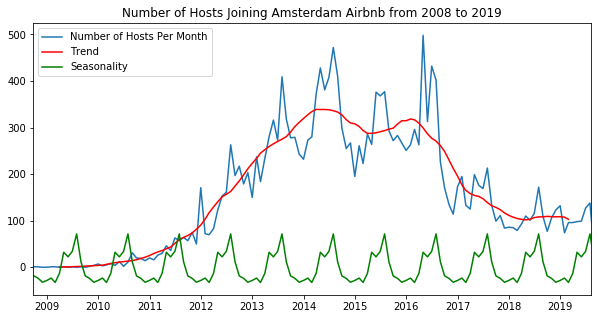

In [48]:
fig, ax = plt.subplots(figsize=(10 , 5))

plt.title('Number of Hosts Joining Amsterdam Airbnb from 2008 to 2019')
plt.plot(df_clean.set_index('host_since').resample('M', 'size'), label = 'Number of Hosts Per Month')

# Decompose using additive model
decomp = seasonal_decompose(df_clean.set_index('host_since').resample('M', 'size'))
plt.plot(decomp.trend.index, decomp.trend, c = 'r', label = 'Trend')
plt.plot(decomp.trend.index, decomp.seasonal, c = 'g', label = 'Seasonality')

plt.xlim('2008-09-24', '2019-08-08')
plt.legend()

plt.show()

In [49]:
# What is the peak month of hosts joining?
print('What was the peak month?', np.argmax(df_clean.set_index('host_since').resample('M', 'size')).month)
print('When year was this?', np.argmax(df_clean.set_index('host_since').resample('M', 'size')).year)
print('How many hosts joined that month?', df_clean.set_index('host_since').resample('M', 'size').max())

What was the peak month? 4
When year was this? 2016
How many hosts joined that month? 498


The blue line shows the number of hosts joining Airbnb in Amsterdam from the timespan described above. We see that Airbnb started off slow, but really began to pick up in Amsterdam from 2012 to 2014. There are multiple spikes in the data, suggesting that most hosts join in peak months. In fact, the peak time when hosts joined was April of 2016. Spring is in full bloom in April, and this attracts tourists. 

The red line shows the trend of hosts joining Airbnb in Amsterdam. It slowly rises beginning at 2012, but stagnates a bit from 2014 to 2016, and drops from 2017 onwards. According to the [website](https://www.airbnb.com/help/article/1624/i-rent-out-my-home-in-amsterdam-what-shortterm-rental-laws-apply), starting in early 2017, Airbnb’s systems were going to automatically limit entire home listings in Amsterdam to 60 nights per calendar year, which seems to have dropped the number of hosts joining in Amsterdam.  

The green line represents the seasonality of hosts joining during the 11 years. There is a regular patten with noticeable peaks in the spring time.

`last_review` shows the date of the last review for the listed property. This may not be as helpful as `first_review`, which looks at the date a property was first reviewed. Looking at this can help us look at guest attitudes regarding reviewing the Airbnb community.

**Question:** How did guests respond to Airbnb in the first place? When did they start using Airbnb? When did they start reviewing them?

In [50]:
print('In this dataset, the first review was on', df_clean['first_review'].describe()['first'])
print('The most review was on', df_clean['first_review'].describe()['last'])

In this dataset, the first review was on 2009-03-30 00:00:00
The most review was on 2019-08-08 00:00:00


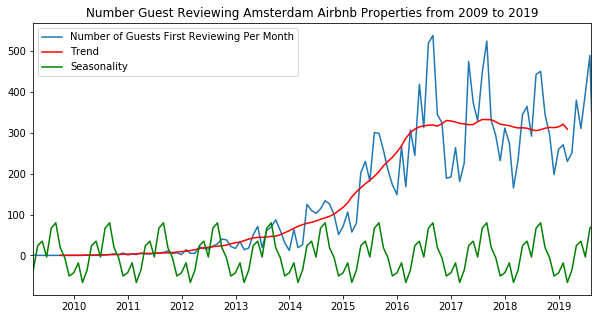

In [51]:
fig, ax = plt.subplots(figsize=(10 , 5))

plt.title('Number Guest Reviewing Amsterdam Airbnb Properties from 2009 to 2019')
plt.plot(df_clean.set_index('first_review').resample('M', 'size'), label = 'Number of Guests First Reviewing Per Month')

# Decompose using additive model
decomp = seasonal_decompose(df_clean.set_index('first_review').resample('M', 'size'))
plt.plot(decomp.trend.index, decomp.trend, c = 'r', label = 'Trend')
plt.plot(decomp.trend.index, decomp.seasonal, c = 'g', label = 'Seasonality')

plt.xlim('2009-03-30', '2019-08-08')
plt.legend()

plt.show()

In [52]:
# What is the peak month of hosts joining?
print('What was the peak month?', np.argmax(df_clean.set_index('first_review').resample('M', 'size')).month)
print('When year was this?', np.argmax(df_clean.set_index('first_review').resample('M', 'size')).year)
print('How many guest first reviewed that month?', df_clean.set_index('first_review').resample('M', 'size').max())

What was the peak month? 8
When year was this? 2016
How many guest first reviewed that month? 539


Generally, guest started reviewing Airbnb homes in Amsterdam from 2015 to 2016. Again, we see a stagnation from 2017 onwards, shown by the trend line. This coincides with the drop and stagnation in the hosts joining. This suggests that though less people were hosting their properties in 2017, guests kept on steadily reviewing the properties that already existed in the listing.

Seasonal-wise, there seems to be a peak of guests reviewing during the fall season, probably after their stay in the Airbnb home during the spring and summer season.

Now that these variables have been looked at, we can drop them from our dataset.

In [53]:
df_clean = df_clean.drop(['host_since', 'last_review', 'first_review'], axis = 1)

## Location Variables

In order to map out Amsterdam and the distribution of variables, I will download the geojson file from [here](http://insideairbnb.com/get-the-data.html).

__Question:__ What is the most expensive neighbourhood to rent an Airbnb? How many listings are in each neighbourhood?

In [54]:
# What variables deal with the location of the property?
location_vars = ['street', 'neighbourhood_cleansed', 'market', 'smart_location', 'latitude', 'longitude', 'is_location_exact']

In [55]:
# From the InsideAirbnb website
geo_df = gpd.read_file('data/neighbourhoods.geojson')

In [56]:
neighbourhood_df = pd.DataFrame(df_clean.groupby('neighbourhood_cleansed').size())
neighbourhood_df = neighbourhood_df.rename(columns = {0 : 'num_listings'})

neighbourhood_df['median_price'] = df_clean.groupby('neighbourhood_cleansed')['price'].agg({'median_price': np.median})

geo_df_complete = geo_df.set_index('neighbourhood').join(neighbourhood_df)

In [57]:
# For annotating neighbourhoods
geo_df_complete['coords'] = geo_df_complete['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_df_complete['coords'] = [coords[0] for coords in geo_df_complete['coords']]

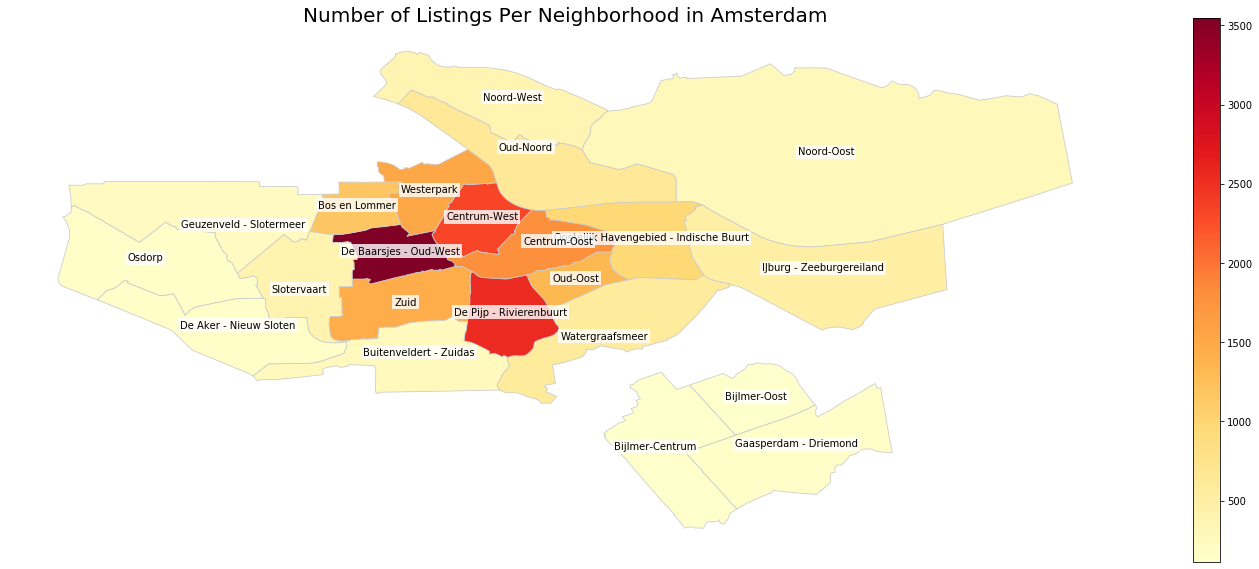

In [58]:
# Number of listings per neighbourhood
vmin, vmax = geo_df_complete['num_listings'].min(), geo_df_complete['num_listings'].max()
fig, ax = plt.subplots(figsize = (25, 10))
ax.axis('off')
ax.set_title('Number of Listings Per Neighborhood in Amsterdam', fontdict = {'fontsize': '20', 'fontweight': '3'})

# Colorbar
sm = plt.cm.ScalarMappable(cmap = 'YlOrRd', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm)

geo_df_complete.plot(ax = ax, column = 'num_listings', cmap = 'YlOrRd', linewidth = 0.8, edgecolor = '0.8')

for i, row in geo_df_complete.iterrows():
    ax.text(row.coords[0], row.coords[1], s=i, fontsize = 10, ha = 'center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.show()

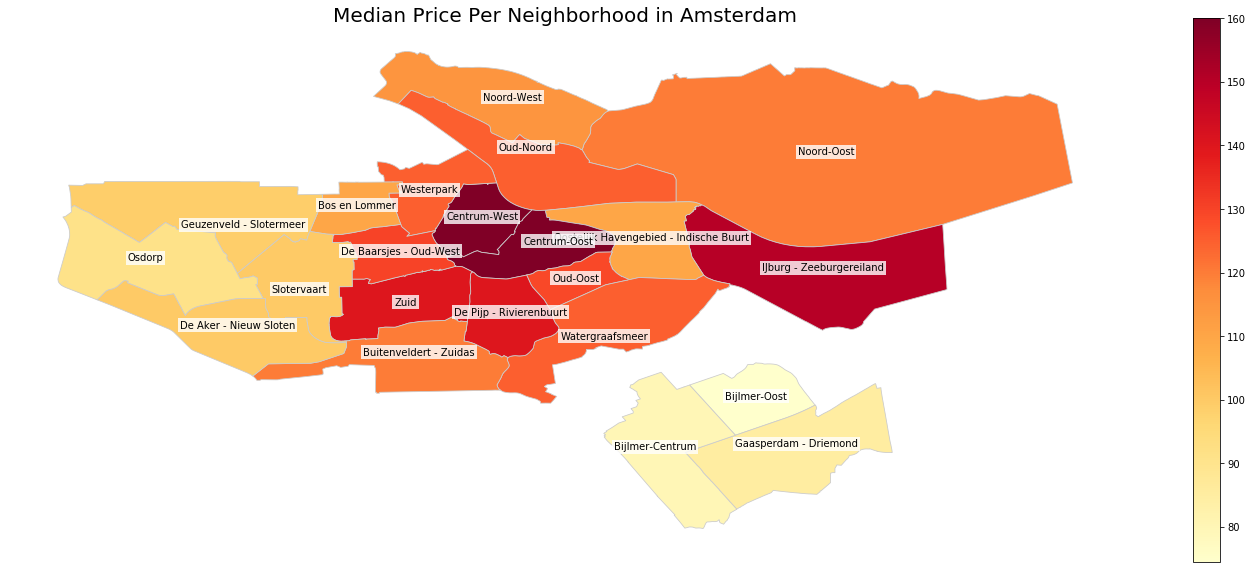

In [59]:
# Median price per neighbourhood
vmin, vmax = geo_df_complete['median_price'].min(), geo_df_complete['median_price'].max()
fig, ax = plt.subplots(figsize = (25, 10))
ax.axis('off')
ax.set_title('Median Price Per Neighborhood in Amsterdam', fontdict = {'fontsize': '20', 'fontweight': '3'})

# Colorbar
sm = plt.cm.ScalarMappable(cmap = 'YlOrRd', norm = plt.Normalize(vmin = vmin, vmax = vmax))
sm._A = []
cbar = fig.colorbar(sm)

geo_df_complete.plot(ax = ax, column = 'median_price', cmap = 'YlOrRd', linewidth = 0.8, edgecolor = '0.8')

for i, row in geo_df_complete.iterrows():
    ax.text(row.coords[0], row.coords[1], s=i, fontsize = 10, horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.show()

**Note: The neighbourhood to the immediate right of Centrum-Oost is called Oostelijik Havengebied - Indische Buurt.** 

Above are two plots of Amsterdam as well as the distribution of median price and number of listings within its various neighborhoods.

In the first plot, we see that many Airbnb properties are in the central Amsterdam region. The neighborhood with the most listings is De Baarsjes - Oud West, which is a major shopping district in Amsterdam. Regions farther from the center have less properties.

However, in the second plot, we see a wider distribution of prices across all of Amsterdam. The most expensive listings show up in Centrum-West, Centrum-East, and Ijburg - Zeeburgereiland. Centrum-West and Centrum-East are located in the center of Amsterdam, and it makes sense that they would have expensive listings. However, Ijburg - Zeeburgereiland is located closer towards the outskirts of Amsterdam. It had less listings, but was almost as expensive as listings closer to the center. This could be due to the fact that this artificial area was created recently. New housing projects had just sprouted up here less than a decade ago.

Initially, I thought that kasfbkjasbdcjklas

## Categorical Variables

In [60]:
# What are the categorical variables? Exclude location variables
categ_vars = [col for col in df_clean.columns if df_clean[col].dtype == 'object' and col not in location_vars]

print(categ_vars)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'property_type', 'room_type', 'bed_type', 'amenities', 'extra_people', 'calendar_updated', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']


__Question:__ What's the relationship between ratings and `price`?

Before analyzing this, I will clean up the data by categorizing each of the different ratings. There will be six categories:
I will note that only `review_scores_rating` has scores from 1 to 100. The rest are rated on a 1 to 10 scale. The criteria for each grade for those variables is shown in parenthesis.

- __A+ rating__: A score over 95 (10)
- __A rating__: A score between 90 and 100 (9)
- __B rating__: A score between 80 and 89 (8)
- __C rating__: A score between 70 and 79 (7)
- __D rating__: A score between 60 and 69 (6)
- __F rating__: A score below 59 (5 and below)
- __no review__: No score received

These ratings will be used instead of the original, given variables. As such, I will drop the other `review_scores_x` variables and not include them in my model training.

In [61]:
def categorize_score(score):
    """
    Categorizes the given score by using the above scheme.
    Applies only to review_scores_rating.
    """
    if (score == 'no review') | (score == 'no response'):
        return 'Missing'
    
    if int(score) >= 95:
        return 'A+'
    elif int(score) >= 90 and int(score) <= 94:
        return 'A'
    elif int(score) >= 80 and int(score) <= 89:
        return 'B'
    elif int(score) >= 70 and int(score) <= 79:
        return 'C'
    elif int(score) >= 60 and int(score) <= 69:
        return 'D'
    elif int(score) <= 59:
        return 'F'
    
def categorize_score_alt(score):
    """
    Alteration of the above function for use with a different range of ratings.
    """
    if score == 'no review':
        return 'Missing'
    elif int(score) == 10:
        return 'A+'
    elif int(score) == 9:
        return 'A'
    elif int(score) == 8:
        return 'B'
    elif int(score) == 7:
        return 'C'
    elif int(score) == 6:
        return 'D'
    elif int(score) <= 5:
        return 'F'

In [62]:
for review_var in [var for var in df_clean.columns if 'review_scores_' in var]:
    if review_var == 'review_scores_rating':
        df_clean['cleaned_' + review_var] = df_clean[review_var].apply(categorize_score)
    else:
        df_clean['cleaned_' + review_var] = df_clean[review_var].apply(categorize_score_alt)

# Number of listings per rating for each rating criteria
cleaned_review_scores_rating = df_clean.groupby('cleaned_review_scores_rating').size()
cleaned_review_scores_accuracy = df_clean.groupby('cleaned_review_scores_accuracy').size()
cleaned_review_scores_cleanliness = df_clean.groupby('cleaned_review_scores_cleanliness').size()
cleaned_review_scores_checkin = df_clean.groupby('cleaned_review_scores_checkin').size()
cleaned_review_scores_communication = df_clean.groupby('cleaned_review_scores_communication').size()
cleaned_review_scores_location = df_clean.groupby('cleaned_review_scores_location').size()
cleaned_review_scores_value = df_clean.groupby('cleaned_review_scores_value').size()

cleaned_review_df = pd.concat([cleaned_review_scores_rating, cleaned_review_scores_accuracy, 
           cleaned_review_scores_cleanliness, cleaned_review_scores_checkin, 
           cleaned_review_scores_communication, cleaned_review_scores_location, 
           cleaned_review_scores_value], 
          axis = 1)

cleaned_review_df = cleaned_review_df.rename(columns = {
    0 : 'cleaned_ratings',
    1 : 'cleaned_accuracy',
    2 : 'cleaned_cleanliness',
    3 : 'cleaned_checkin',
    4 : 'cleaned_communication',
    5 : 'cleaned_location',
    6 : 'cleaned_value'
})

In [63]:
# Keep track of these new variables
categ_vars.append('cleaned_review_scores_rating')
categ_vars.append('cleaned_review_scores_accuracy')
categ_vars.append('cleaned_review_scores_cleanliness')
categ_vars.append('cleaned_review_scores_checkin')
categ_vars.append('cleaned_review_scores_communication')
categ_vars.append('cleaned_review_scores_location')
categ_vars.append('cleaned_review_scores_value')

In [64]:
# Switch A+ and A
cleaned_review_df = pd.concat([cleaned_review_df.loc[['A+'],:], cleaned_review_df.drop('A+', axis=0)], axis=0)

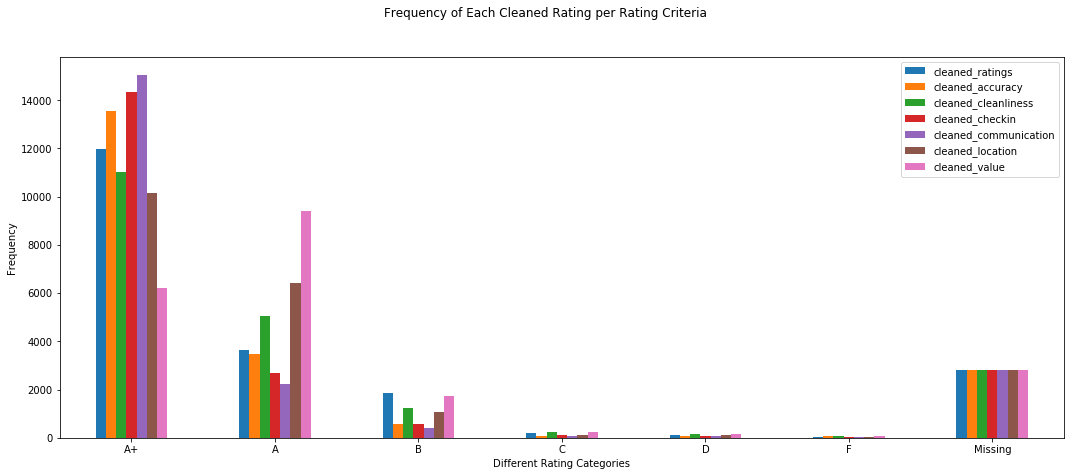

In [65]:
# Distribution of review scores in Amsterdam
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Frequency of Each Cleaned Rating per Rating Criteria')
plt.xlabel('Different Rating Categories')
plt.ylabel('Frequency')
cleaned_review_df.plot.bar(ax = ax, rot = 0)
plt.show()

We see above the distribution of review scores for each criteria. A majority of properties recieved an A+ or an A rating across the range of criteria. Most of the properties recieved a score of over 95 for `review_scores_rating`. In terms of `review_scores_value`, more properties got an A rather than an A+. Asides from these two ratings, it would seem that most guests left no review. This could be either due to the property having never been rented, or to guests choosing to not leave a review rather than a negative or positive one.

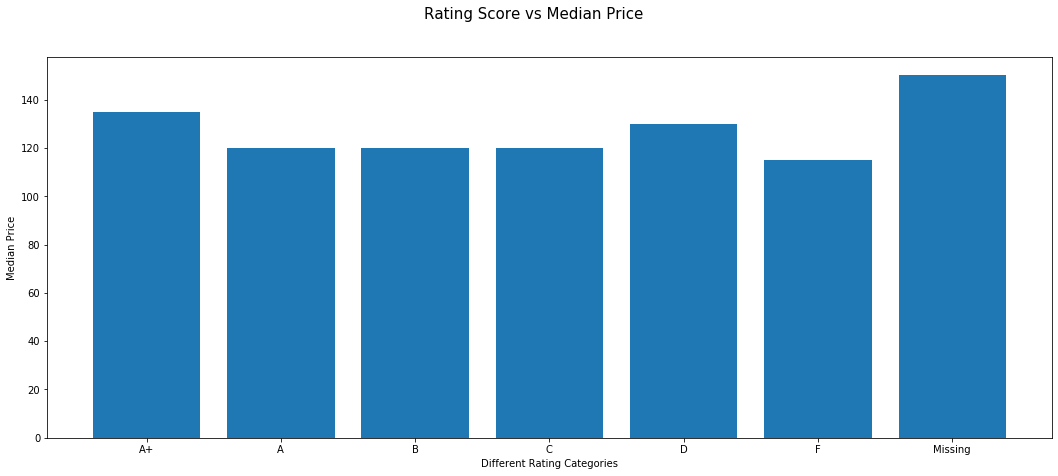

In [66]:
# Append median price
median_prices_by_score = []
for score in cleaned_review_df.index:
    # Get all rows with that score
    query_rows = df_clean[df_clean['cleaned_review_scores_rating'] == score]
    median_price = query_rows['price'].median()
    median_prices_by_score.append(median_price)

# Append to cleaned_review_df
cleaned_review_df['median_price'] = median_prices_by_score

# Distribution of Median Price per Rating
fig, ax = plt.subplots(figsize = (18, 7))
fig.suptitle('Rating Score vs Median Price', fontsize = 15)
plt.bar(x = cleaned_review_df.index, height = 'median_price', data = cleaned_review_df)
plt.xlabel('Different Rating Categories')
plt.ylabel('Median Price')
plt.show()

Above we see the distribution of median listing prices for `review_scores_rating`. I used this rating instead because it is an aggregation of the other rating criteria in the dataset. We see that prices are generally the same across all different ratings. In fact, several of the ratings on the lower end were priced slightly more than those that got better ratings. This reinforces that given that hosts get to choose the price of their property, they would all price it relatively high.We see that the median price is highest for when properties got no review. This could be due to guests not being able to go to those properties because they are more expensive.

__Question:__ Does being a superhost get you more guests? How much do they charge? What are their ratings like?

In order to answer this, I will look at `number_of_reviews` as a measure of the number of guests that used a particular property.

In [67]:
# Array to keep track of boolean variables
categ_bool_vars = []

In [68]:
# Boolean encode
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
categ_bool_vars.append('host_is_superhost')

In [69]:
num_superhosts = np.count_nonzero(df_clean['host_is_superhost'])
num_reviews_superhost = df_clean.groupby('host_is_superhost')['number_of_reviews'].sum()[1]
num_reviews_not_superhost = df_clean.groupby('host_is_superhost')['number_of_reviews'].sum()[0]
median_price_superhost = df_clean.groupby('host_is_superhost')['price'].median()[1]
median_price_not_superhost = df_clean.groupby('host_is_superhost')['price'].median()[0]

superhosts_data = pd.DataFrame({
    'Is Superhost?': ['Yes', 'No'],
    'Amount': [num_superhosts, df_clean.shape[0] - num_superhosts],
    'No. Reviews': [num_reviews_superhost, num_reviews_not_superhost],
    'Median Price': [median_price_superhost, median_price_not_superhost]
})

superhosts_data.set_index('Is Superhost?', inplace = True)

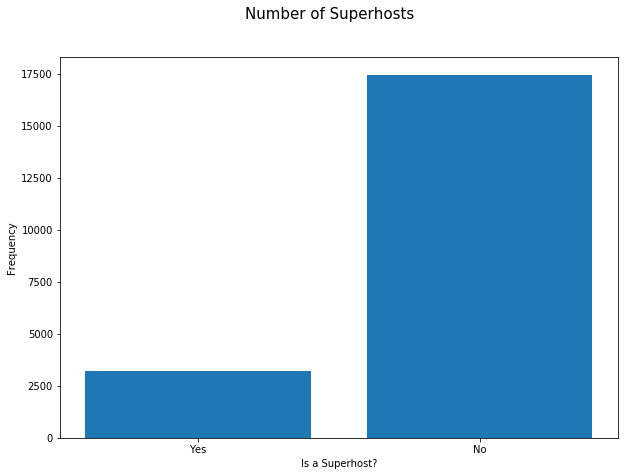

In [70]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Superhosts', fontsize = 15)
plt.bar(x = superhosts_data.index, height = 'Amount', data = superhosts_data)
plt.xlabel('Is a Superhost?')
plt.ylabel('Frequency')
plt.show()

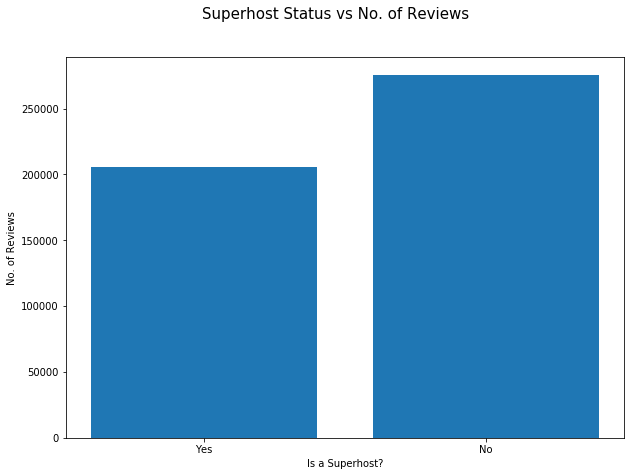

In [71]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Superhost Status vs No. of Reviews', fontsize = 15)
plt.bar(x = superhosts_data.index, height = 'No. Reviews', data = superhosts_data)
plt.xlabel('Is a Superhost?')
plt.ylabel('No. of Reviews')
plt.show()

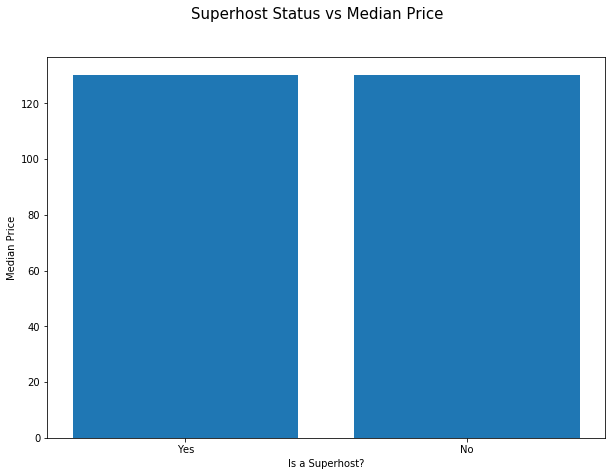

In [72]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Superhost Status vs Median Price', fontsize = 15)
plt.bar(x = superhosts_data.index, height = 'Median Price', data = superhosts_data)
plt.xlabel('Is a Superhost?')
plt.ylabel('Median Price')
plt.show()

Above are two plots detailing the number of superhosts in the data as well as the number of reviews each superhost got. A majority of the hosts are not superhosts, which could also explain why non-superhosts get more reviews. The median price for superhost status are both the same at \$130. Even though there are more non-superhosts, superhosts perhaps charge as much for their properties given their status.

In [73]:
s1 = df_clean[df_clean['cleaned_review_scores_rating'] == 'A+'].groupby('host_is_superhost').size()
s2 = df_clean[df_clean['cleaned_review_scores_rating'] == 'A'].groupby('host_is_superhost').size()
s3 = df_clean[df_clean['cleaned_review_scores_rating'] == 'B'].groupby('host_is_superhost').size()
s4 = df_clean[df_clean['cleaned_review_scores_rating'] == 'C'].groupby('host_is_superhost').size()
s5 = df_clean[df_clean['cleaned_review_scores_rating'] == 'D'].groupby('host_is_superhost').size()
s6 = df_clean[df_clean['cleaned_review_scores_rating'] == 'F'].groupby('host_is_superhost').size()
s7 = df_clean[df_clean['cleaned_review_scores_rating'] == 'No Review'].groupby('host_is_superhost').size()

superhost_ratings_df = pd.concat([s1, s2, s3, s4, s5, s6, s7], axis = 1)

superhost_ratings_df = superhost_ratings_df.rename(columns = {
    0 : 'A+',
    1 : 'A',
    2 : 'B',
    3 : 'C',
    4 : 'D',
    5 : 'F',
    6 : 'No Review'
})

superhost_ratings_df.fillna(0, inplace = True)
superhost_ratings_df.rename(index={0: 'Not a Superhost', 1: 'Is a Superhost'}, inplace = True)

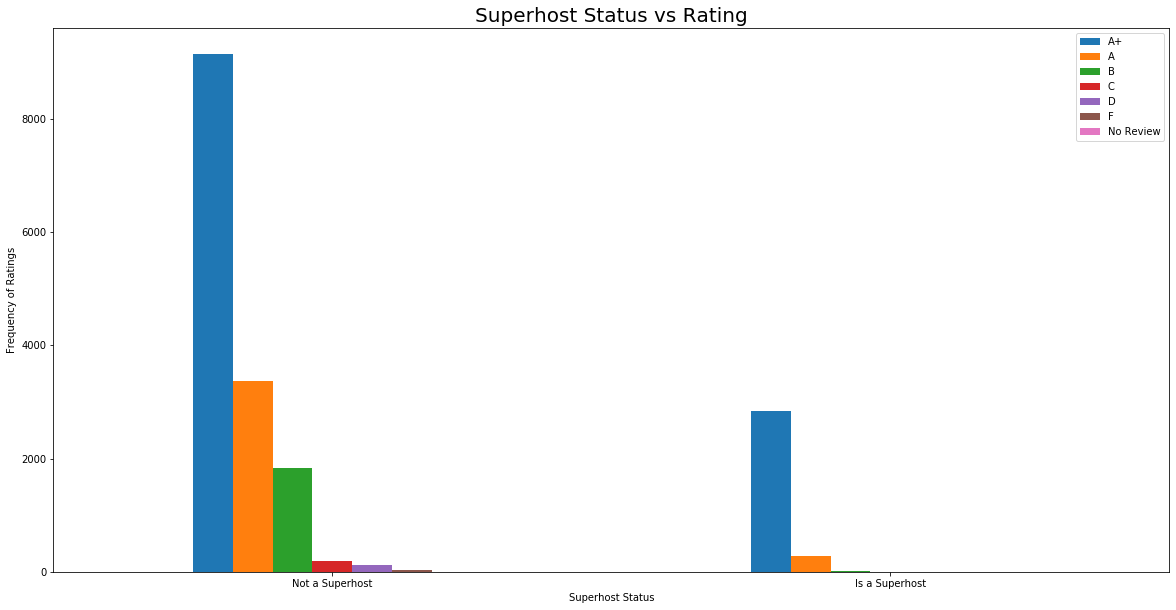

In [74]:
fig, ax = plt.subplots(figsize=(20, 10))
superhost_ratings_df.plot.bar(ax = ax, rot = 0)
plt.title('Superhost Status vs Rating', fontsize = 20)
plt.xlabel('Superhost Status')
plt.ylabel('Frequency of Ratings')
plt.show()

Above we see how superhost status is related to the types of ratings the property gets. The rating is based on `cleaned_review_scores_rating`, as it is an aggregation of all other rating scores. It would seem that regardless of superhost status, hosts get a high rating. The pink bar shows the amount of properties that recieved no review. The reason that the pink bar for non-superhosts is much larger than the pink bar for superhosts may be due to non-superhosts being relatively new. As such, it is possible that their properties were not rented out yet. 

__Question:__ What is the most common amenity?

Before I go into exploring `amenities`, I should first clean it up a bit first. Initially, the `amenities` for each observation is an array of amenities provided for guests staying at the property. I will get all of the unique amenities first. From there, I will do some cleaning.

In [75]:
# Example of amenities for the first property
df_clean.loc[0, 'amenities']

'{Internet,Wifi,"Paid parking off premises","Buzzer/wireless intercom",Heating,Washer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Private entrance","Hot water","Bed linens","Extra pillows and blankets","Single level home","Garden or backyard","No stairs or steps to enter","Flat path to guest entrance","Well-lit path to entrance","No stairs or steps to enter","Accessible-height bed","No stairs or steps to enter","Host greets you","Handheld shower head","Paid parking on premises"}'

In [76]:
uniq_amenities = []

for row in df_clean['amenities']:
    for amenity in row[1:-1].replace('"', '').split(','):
        if amenity not in uniq_amenities:
            uniq_amenities.append(amenity)
    
print('Number of unique amenities:', len(uniq_amenities))

Number of unique amenities: 126


In [77]:
# Delete those with translation missing
uniq_amenities = [amenity for amenity in uniq_amenities if 'translation missing' not in amenity]
# Delete empty strings
uniq_amenities = [amenity for amenity in uniq_amenities if amenity]

print('Number of unique amenities after some cleaning:', len(uniq_amenities))

Number of unique amenities after some cleaning: 123


Below I aggregate similar amenities into boolean columns, where 1 represents that that property has the amenity, and 0 when the property does not.

In [78]:
# Combine the same amenities into one eg. internet and Wifi are the same thing
df_clean.loc[df_clean['amenities'].str.lower().str.contains('bbq'), 'bbq'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('outlet covers'), 'outlet_covers'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('gym'), 'gym'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('mobile hoist'), 'mobile_hoist'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('air purifier'), 'air_purifier'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('doorman'), 'doorman'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('building staff'), 'building_staff'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('hot water kettle'),'hot_water_kettle'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('suitable for events'),'event_suitable'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('air conditioning'),'ac'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('other'),'other'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('room-darkening'),'room_shades'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('luggage dropoff'),'luggage_dropoff'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('charger'),'ev_charger'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('pocket wifi|wifi|internet|ethernet'),'internet'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('wireless intercom|buzzer'),'buzzer'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('heating'),'heating'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('washer|dryer|washer / dryer'),'washer_or_dryer'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('shower|essentials|shampoo|bed|pillows|toilet|mattress|shower|bathroom'),'bed_and_bath_essentials'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('keypad|lock on bedroom door|private|lockbox'),'privacy'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('24-hour'),'24_hr_checkin'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('hangers'),'hangers'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('hair dryer'),'hair_dryer'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('iron'),'iron'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('laptop friendly'),'laptop_friendly'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('hot water'),'hot_water'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('garden|backyard|lake|beach|waterfront|beachfront|ski-in/ski-out'),'outdoor'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('wheelchair|accessible|no stairs|well-lit|flat path|wide|extra space|access|disabled'),'accessible'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('single level home'),'single_level_home'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('handheld shower head'),'handheld_shower_head'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('parking'),'parking'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('tv|cable tv'),'television'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('refrigerator|kitchen|microwave|cooking basics|dishes and silverware|dinnerware'),'kitchen_basics'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('long term stays allowed'),'long_term_stays'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('elevator'),'elevator'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('indoor fireplace'),'indoor_fireplace'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('dryer'),'dryer'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('smoking allowed'),'smoking_allowed'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('coffee maker'),'coffee_maker'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('dishwasher'),'dishwasher'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('oven'),'oven'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('stove'),'stove'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('bathtub'),'bathtub'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('cleaning before checkout'),'cleaning_before_checkout'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('breakfast'),'breakfast'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('self check-in'),'self_checkin'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('tv|cable tv'),'television'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('other pet(s)|Dog(s)|Cat(s)|Pets live on this property|pet'), 'pet_accessibility'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('gates|high chair|crib|baby monitor|child|children|kids|kids|baby|changing table|guards|gates'),'kid_friendly'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('game console'),'high_end_electronics'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('host greets you'),'host_greets_you'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('carbon monoxide alarm|fire extinguisher|first aid kit|smoke alarm|safety card'),'safety_features'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('patio or balcony'),'patio_or_balcony'] = 1
df_clean.loc[df_clean['amenities'].str.lower().str.contains('hot tub|pool'),'hot_tub_or_pool'] = 1


In [79]:
# Replace NaNs with 0s in the new columns
df_clean.loc[:, 'bbq':] = df_clean.loc[:, 'bbq':].fillna(0)

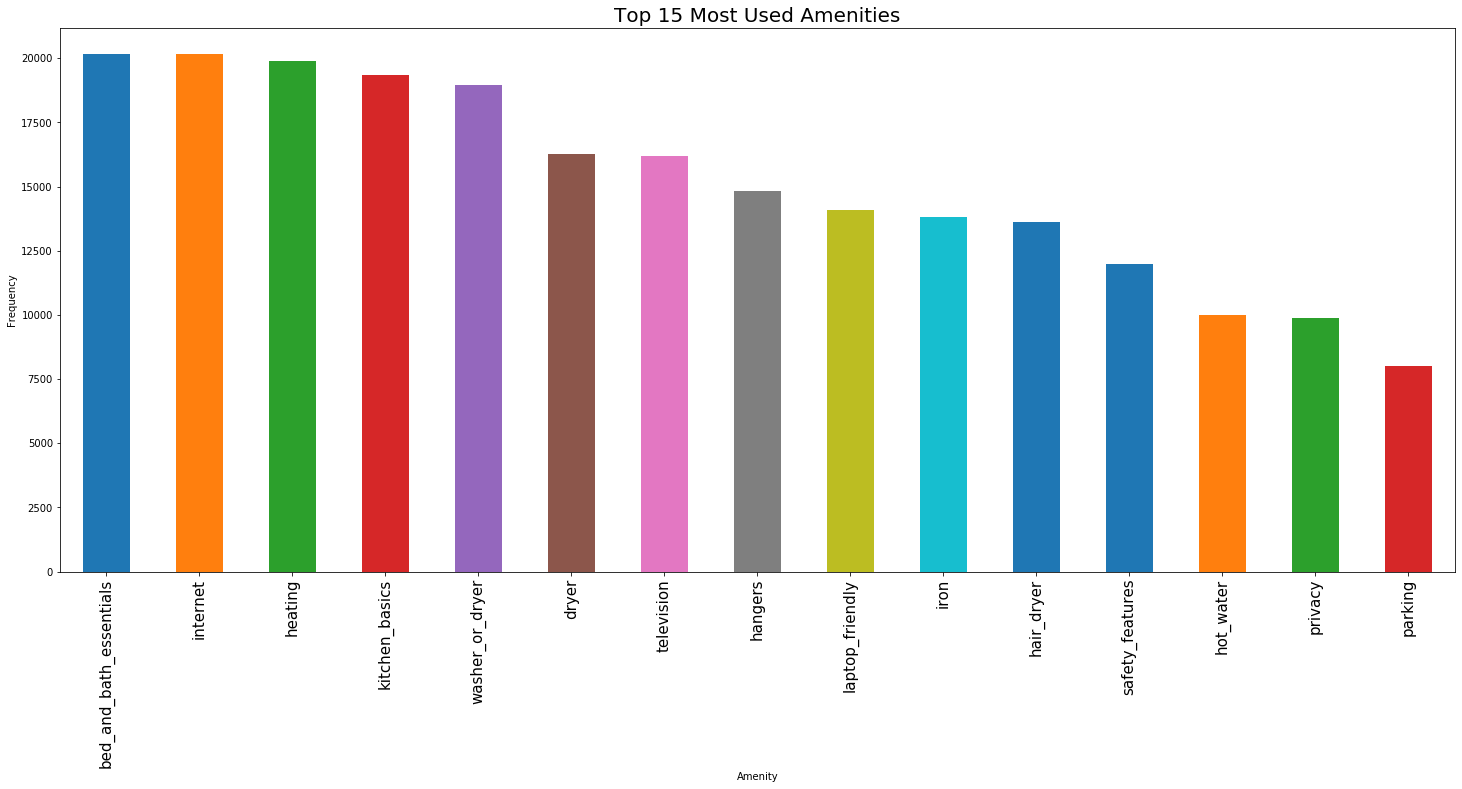

In [80]:
# What are the most used amenities?
fig, ax = plt.subplots(figsize=(25, 10))
plt.title('Top 15 Most Used Amenities', fontsize = 20)
df_clean.loc[:, 'bbq':].sum().nlargest(15).plot.bar(ax = ax)
plt.xticks(fontsize = 15)
plt.xlabel('Amenity')
plt.ylabel('Frequency')
plt.show()

Above we can see the distribution of the top 15 most common amenities in the dataset. It should be noted that the vast majority of the observations have some sort of bed and bath essential, which makes sense given that is the most essential amenity a host can provide for their guests. In 15th place is parking, so it would seem that some locations do not provide some sort of free or accessible parking for its guests. 

Given the vast majority of properties have the amenities shown above, it is safe to assume that plotting the rest of the amenities against median price or rating would be swayed by these top 15 variables, especially `bed_and_bath_essenitals`.

Also, I one-hot encoded these amenities, so I will keep track of them below.

In [81]:
amenity_bool_vars = [col for col in df_clean.loc[:, 'bbq':].columns]

__Question:__ Does having a profile picture get you more guests? 

Again, I will use `number_of_reviews`.

In [82]:
# Boolean encode
df_clean['host_has_profile_pic'] = df_clean['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
categ_bool_vars.append('host_has_profile_pic')

In [83]:
num_with_pic = np.count_nonzero(df_clean['host_has_profile_pic'])
num_reviews_pic = df_clean.groupby('host_has_profile_pic')['number_of_reviews'].sum()[1]
num_reviews_not_pic = df_clean.groupby('host_has_profile_pic')['number_of_reviews'].sum()[0]

pic_data = pd.DataFrame({
    'Has Profile Pic?': ['Yes', 'No'],
    'Amount': [num_with_pic, df_clean.shape[0] - num_with_pic],
    'No. Reviews': [num_reviews_pic, num_reviews_not_pic]
})

pic_data.set_index('Has Profile Pic?', inplace = True)

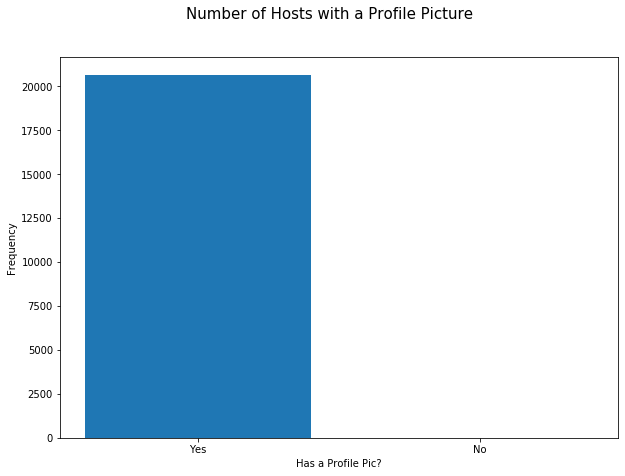

In [84]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Number of Hosts with a Profile Picture', fontsize = 15)
plt.bar(x = pic_data.index, height = 'Amount', data = pic_data)
plt.xlabel('Has a Profile Pic?')
plt.ylabel('Frequency')
plt.show()

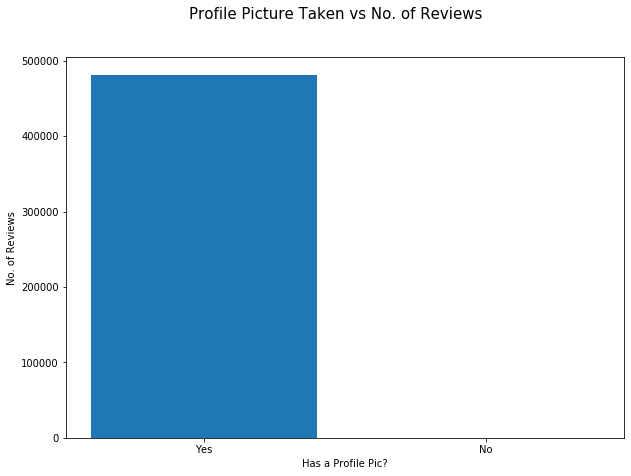

In [85]:
fig, ax = plt.subplots(figsize = (10, 7))
fig.suptitle('Profile Picture Taken vs No. of Reviews', fontsize = 15)
plt.bar(x = pic_data.index, height = 'No. Reviews', data = pic_data)
plt.xlabel('Has a Profile Pic?')
plt.ylabel('No. of Reviews')
plt.show()

We see from above that the vast majority of hosts have a profile picture. Such a huge difference explains the discrepancy between the amount of reviews hosts with a profile picture get versus those without one. 

__Question:__ How does the type of property affect `price`? Ratings?

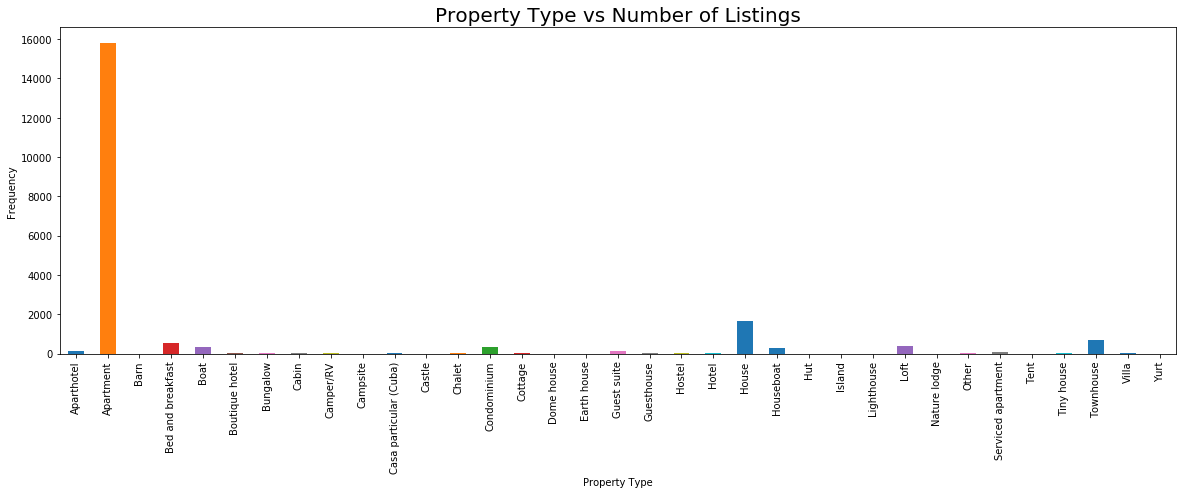

In [86]:
# Most common property type
property_type_num_listings = df_clean.groupby('property_type').size()
fig, ax = plt.subplots(figsize=(20, 6))
property_type_num_listings.plot.bar(ax = ax)
plt.title('Property Type vs Number of Listings', fontsize = 20)
plt.xlabel('Property Type')
plt.ylabel('Frequency')
plt.show()

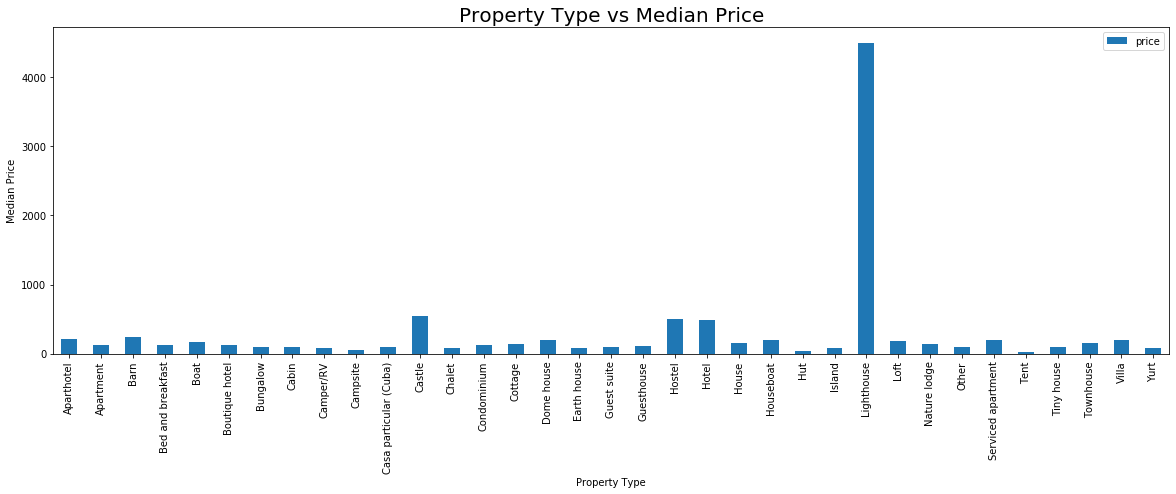

In [87]:
property_type_median_price_df = pd.DataFrame(df_clean.groupby('property_type').median()['price'])
fig, ax = plt.subplots(figsize=(20, 6))
property_type_median_price_df.plot.bar(ax = ax)
plt.title('Property Type vs Median Price', fontsize = 20)
plt.xlabel('Property Type')
plt.ylabel('Median Price')
plt.show()

This graph shows that most of the property types get relatively similar prices. The outlier would be the lighthouse, but that is understandable given that lighthouses are rare properties and there is little to no reason to rent a lighthouse over a conventional apartment or home.

In [88]:
s1 = df_clean[df_clean['cleaned_review_scores_rating'] == 'A+'].groupby('property_type').size()
s2 = df_clean[df_clean['cleaned_review_scores_rating'] == 'A'].groupby('property_type').size()
s3 = df_clean[df_clean['cleaned_review_scores_rating'] == 'B'].groupby('property_type').size()
s4 = df_clean[df_clean['cleaned_review_scores_rating'] == 'C'].groupby('property_type').size()
s5 = df_clean[df_clean['cleaned_review_scores_rating'] == 'D'].groupby('property_type').size()
s6 = df_clean[df_clean['cleaned_review_scores_rating'] == 'F'].groupby('property_type').size()
s7 = df_clean[df_clean['cleaned_review_scores_rating'] == 'No Review'].groupby('property_type').size()

property_type_ratings_df = pd.concat([s1, s2, s3, s4, s5, s6, s7], axis = 1)

property_type_ratings_df = property_type_ratings_df.rename(columns = {
    0 : 'A+',
    1 : 'A',
    2 : 'B',
    3 : 'C',
    4 : 'D',
    5 : 'F',
    6 : 'No Review'
})

property_type_ratings_df.fillna(0, inplace = True)
property_type_ratings_df

,A+,A,B,C,D,F,No Review
Aparthotel,25.0,16.0,16.0,3.0,3.0,0.0,0.0
Apartment,9132.0,2853.0,1463.0,156.0,98.0,22.0,0.0
Barn,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Bed and breakfast,294.0,127.0,73.0,4.0,1.0,1.0,0.0
Boat,205.0,62.0,35.0,7.0,3.0,1.0,0.0
Boutique hotel,14.0,13.0,7.0,0.0,0.0,0.0,0.0
Bungalow,2.0,1.0,0.0,0.0,0.0,0.0,0.0
Cabin,6.0,3.0,0.0,0.0,0.0,0.0,0.0
Camper/RV,0.0,0.0,2.0,0.0,0.0,0.0,0.0
Campsite,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Above we can see the dataframe for the distribution of `review_scores_rating` for each property type. Many of the property types did not recieve a rating. For instance, the one Island in the dataset got an A+. Plotting this against the other datasets will make it difficult to see the overall distribution of ratings per property type. Additionally, one can consider such property types as outliers. So, I have decided to plot the two most common property types below: Houses and Apartments.

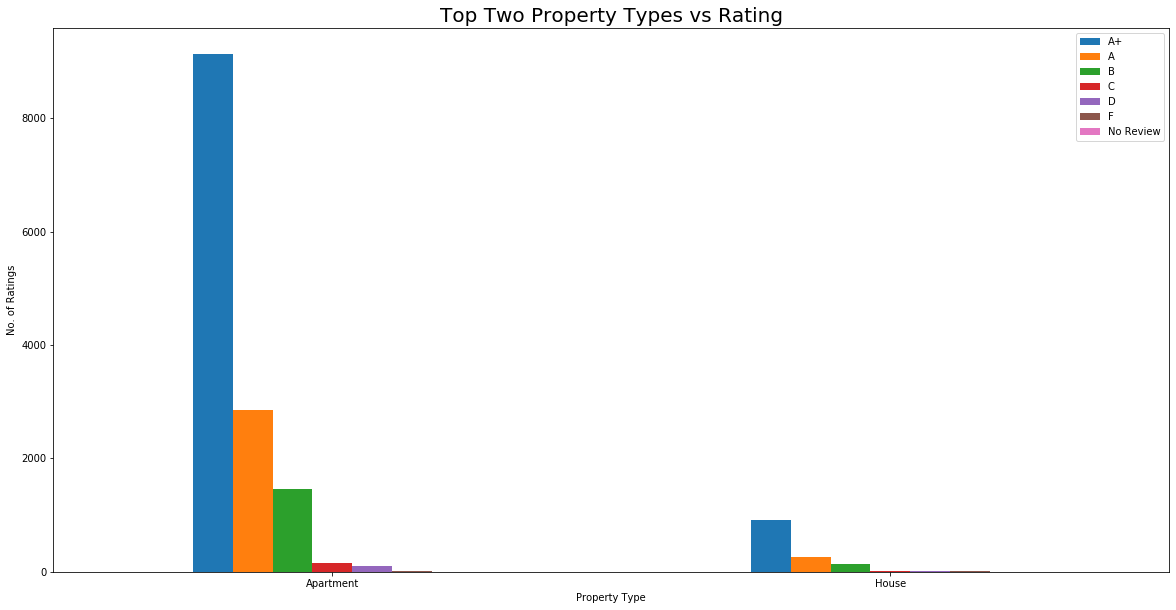

In [89]:
fig, ax = plt.subplots(figsize=(20, 10))
property_type_ratings_df.loc[['Apartment', 'House']].plot.bar(ax = ax, rot = 0)
plt.title('Top Two Property Types vs Rating', fontsize = 20)
plt.xlabel('Property Type')
plt.ylabel('No. of Ratings')
plt.show()

As we can see, many apartments recieved an A+ or an A. The same goes for houses. However, a majority of the properties in the dataset were apartments, which explains the huge discrepancy in terms of ratings between apartments and the rest of the property types. 

### Additional Cleaning

Below, I do some additional cleaning on the other categorical variables.


#### `host_response_rate`

I will treat `host_response_rate` like `review_scores_x`, and categorize the different rates into A+, A, B, etc. 

In [90]:
df_clean['cleaned_host_response_rate'] = df_clean['host_response_rate'].str.replace('%', '').apply(categorize_score)
categ_vars.append('cleaned_host_response_rate')

#### More Boolean Variables

In [91]:
# More boolean variables
df_clean['is_location_exact'] = df_clean['is_location_exact'].apply(lambda x: 1 if x == 't' else 0)
categ_bool_vars.append('is_location_exact')

df_clean['instant_bookable'] = df_clean['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
categ_bool_vars.append('instant_bookable')

df_clean['require_guest_phone_verification'] = df_clean['require_guest_phone_verification'].apply(lambda x: 1 if x == 't' else 0)
categ_bool_vars.append('require_guest_phone_verification')

df_clean['require_guest_profile_picture'] = df_clean['require_guest_profile_picture'].apply(lambda x: 1 if x == 't' else 0)
categ_bool_vars.append('require_guest_profile_picture')

#### `host_verifications`

Like `amenities`, `host_verifications` comes as an array of the host's verifications, shown below. I will clean it similar to how I cleaned `amenities`.

In [92]:
df_clean.loc[0, 'host_verifications']

"['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']"

In [93]:
uniq_verifications = []

for row in df_clean['host_verifications']:
    for verification in row[1:-1].replace('"', '').replace(' ', '').split(','):
        if verification not in uniq_verifications:
            uniq_verifications.append(verification)
    
print('Number of unique verifications:', len(uniq_verifications))

Number of unique verifications: 20


In [94]:
# Delete empty strings
uniq_verifications = [v for v in uniq_verifications if v]

print('Number of unique verifications after some cleaning:', len(uniq_verifications))

Number of unique verifications after some cleaning: 19


In [95]:
# One hot encode each verification
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('email|work_email'), 'email'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('phone'), 'phone'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('reviews'), 'jumio'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('government'), 'government'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('selfie'), 'selfie'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('identity_manual'), 'id_manual'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('facebook'), 'fb'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('google'), 'google'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('manual'), 'manual'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('sent_id'), 'sent_id'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('kba'), 'kba'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('weibo'), 'weibo'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('selfie'), 'selfie'] = 1
df_clean.loc[df_clean['host_verifications'].str.lower().str.contains('sesame'), 'sesame'] = 1

In [96]:
# Get rid of NaNs
df_clean.loc[:, 'email':] = df_clean.loc[:, 'email':].fillna(0)

In [97]:
# Keep track of these
verification_bool_vars = [col for col in df_clean.loc[:, 'email':].columns]

### Categorical Encoding and More Visualization

Now, I will get started on ordinally encoding these categorical variables so that I can visualize their relationship with `price`. I will derive an order from the data based on the median `price` for each level of the variable.

This process will be done on these variables:

__Variables to ordinally encode__
- `host_response_time`
- `cleaned_host_response_rate`
- `neighbourhood_cleansed`
- `market`
- `property_type`
- `room_type`
- `bed_type`
- `cleaned_review_scores_x`

__Variables to exlude__:
- `calendar_updated`: It is unclear how this may affect `price`, so I will drop it. 
- `review_scores_x`: I will drop these in favor of the `cleaned_review_scores_x` variables I made earlier.

In [98]:
# Remove unneeded variables
categ_vars.remove('calendar_updated')
categ_vars.remove('review_scores_rating')
categ_vars.remove('review_scores_accuracy')
categ_vars.remove('review_scores_cleanliness')
categ_vars.remove('review_scores_checkin')
categ_vars.remove('review_scores_communication')
categ_vars.remove('review_scores_location')
categ_vars.remove('review_scores_value')
categ_vars.remove('host_response_rate')
categ_vars.remove('extra_people')
categ_vars.remove('amenities')

# Add location variables
categ_vars.append('neighbourhood_cleansed')
categ_vars.append('market')

# Exclude one hot variables
categ_vars = [var for var in categ_vars if var not in categ_bool_vars]

categ_vars

['host_response_time',
 'host_verifications',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy',
 'cleaned_review_scores_rating',
 'cleaned_review_scores_accuracy',
 'cleaned_review_scores_cleanliness',
 'cleaned_review_scores_checkin',
 'cleaned_review_scores_communication',
 'cleaned_review_scores_location',
 'cleaned_review_scores_value',
 'cleaned_host_response_rate',
 'neighbourhood_cleansed',
 'market']

In the next couple of code blocks below, I ordinally encode the categorical variables that were expressed in levels (ie. `review_scores_rating`) and then calculate the Spearman correlation coefficient to visualize the correlations of the different categorical variables against `price`. I encoded the levels using the magnitude of the median price, where higher integer mappings correspond to a greater median price, and vice versa.

In [99]:
def encode(frame, feature):
    """
    Encodes the categorical variables using ordinal encoding based on the magnitude of the median price.
    """
    # Get the median price for each level and sort
    meds = frame[[feature, 'price']].groupby(feature).median()['price']
    meds = meds.sort_values() # Sort in ascending order
    # Create a mapping as a dictionary where keys are labels and values are integers
    mapping = range(1, len(meds) + 1)
    enc_dict = {}
    i = 0
    for f in meds.index:
        enc_dict[f] = mapping[i]
        i = i + 1
    
    for category, mapping in enc_dict.items():
        # Create a new column using the integer mapping sorted by median price
        frame.loc[frame[feature] == category, feature + '_enc'] = mapping

In [100]:
categ_vars_enc = []
for var in categ_vars:  
    encode(df_clean, var)
    categ_vars_enc.append(var + '_enc')
print(categ_vars_enc)

['host_response_time_enc', 'host_verifications_enc', 'property_type_enc', 'room_type_enc', 'bed_type_enc', 'cancellation_policy_enc', 'cleaned_review_scores_rating_enc', 'cleaned_review_scores_accuracy_enc', 'cleaned_review_scores_cleanliness_enc', 'cleaned_review_scores_checkin_enc', 'cleaned_review_scores_communication_enc', 'cleaned_review_scores_location_enc', 'cleaned_review_scores_value_enc', 'cleaned_host_response_rate_enc', 'neighbourhood_cleansed_enc', 'market_enc']


In [101]:
def visualize_categorical_corr(frame, features):
    """
    Plot a graph to visualize the correlations between the encoded categorical variables and price.
    """
    corr_df = pd.DataFrame()
    corr_df['feature'] = features
    corr_df['corr'] = [frame[feat].corr(frame['price'], 'spearman') for feat in features]
    # Sort the correlations in descending order
    corr_df = corr_df.sort_values('corr', ascending = False)
    f, ax = plt.subplots(figsize=(10, 0.5 * len(features)))
    ax.set_title('Barplot of Spearman Coefficient of Categorical Variables vs Price')
    sns.barplot(data = corr_df, y = 'feature', x = 'corr', orient = 'h')

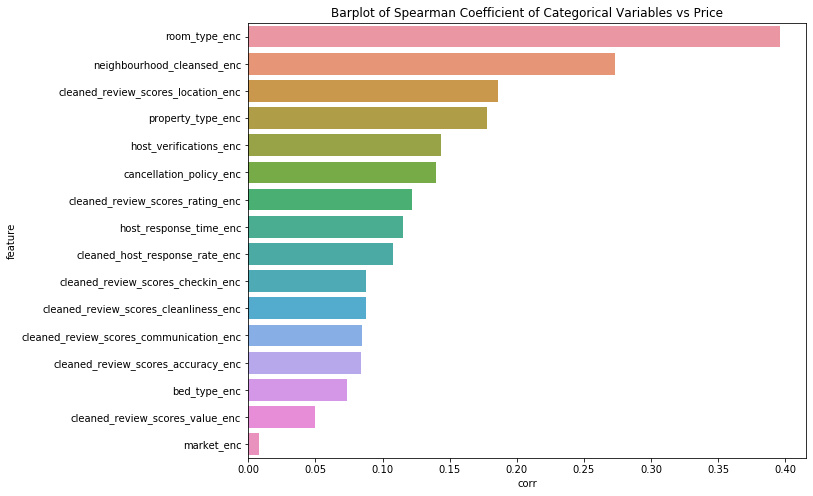

In [102]:
visualize_categorical_corr(df_clean, categ_vars_enc)

Above we can see the correlation between the different categorical variables and `price`. In this case, we see that `room_type` is the most correlated with `price`. This is not a strong correlation because it is about 0.4. 

`neighbourhood_cleansed` is in second place, with its correlation being slightly over 0.25. This is surprising, as one might expect that location is the most correlated with prices of Airbnb homes. However, we have also seen above in the map of median prices versus neighbourhoods that there is a much wider distribution of prices amongst the different neighbourhoods. So, this would suggest that regardless of location, hosts will price their properties similarly. 

I will now check which variables are significant in determining `price` via an ANOVA test.

In [103]:
def determine_sig(frame, var):
    """
    Determines the significance of a categorical variable using an ANOVA test.
    """
    levels = frame[var].unique()
    all_types = [] # List of lists for each level's price
    for level in levels:
        prices = frame[frame[var] == level]['price'].values
        all_types.append(prices)
    
    # ANOVA test
    pval = stats.f_oneway(*all_types)[1]
    if pval < 0.05:
        return True
    else:
        return False

In [104]:
sig_categ_vars = [var for var in categ_vars if determine_sig(df_clean, var)]
sig_categ_vars

['host_response_time',
 'host_verifications',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy',
 'cleaned_review_scores_rating',
 'cleaned_review_scores_accuracy',
 'cleaned_review_scores_cleanliness',
 'cleaned_review_scores_checkin',
 'cleaned_review_scores_communication',
 'cleaned_review_scores_location',
 'cleaned_review_scores_value',
 'cleaned_host_response_rate',
 'neighbourhood_cleansed']

It would seem that the only insignificant variable in determining `price` would be `market`, so I will remove it before training my model.

In [105]:
categ_vars_enc.remove('market_enc')

## Qualitative Variables

Before analyzing these variables, I will get rid of the ones that have redundant information. 

In [106]:
df_clean = df_clean.drop(['minimum_minimum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews_ltm', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis = 1)

In [107]:
# What are the qualitative variables?
quant_vars = [col for col in df_clean.columns if df_clean[col].dtype != 'object' and col not in location_vars and col not in categ_vars]
quant_vars.remove('log_price')

# Exclude from amenity_bool_var, categ_bool_vars, and verification_bool_vars
quant_vars = [var for var in quant_vars if var not in amenity_bool_vars]
quant_vars = [var for var in quant_vars if var not in categ_bool_vars]
quant_vars = [var for var in quant_vars if var not in verification_bool_vars]

print(quant_vars)

['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month', 'days_since_first_review', 'days_since_last_review', 'days_as_host', 'host_response_time_enc', 'host_verifications_enc', 'property_type_enc', 'room_type_enc', 'bed_type_enc', 'cancellation_policy_enc', 'cleaned_review_scores_rating_enc', 'cleaned_review_scores_accuracy_enc', 'cleaned_review_scores_cleanliness_enc', 'cleaned_review_scores_checkin_enc', 'cleaned_review_scores_communication_enc', 'cleaned_review_scores_location_enc', 'cleaned_review_scores_value_enc', 'cleaned_host_response_rate_enc', 'neighbourhood_cleansed_enc', 'market_enc']


In [108]:
df_clean[quant_vars].describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,...,cleaned_review_scores_rating_enc,cleaned_review_scores_accuracy_enc,cleaned_review_scores_cleanliness_enc,cleaned_review_scores_checkin_enc,cleaned_review_scores_communication_enc,cleaned_review_scores_location_enc,cleaned_review_scores_value_enc,cleaned_host_response_rate_enc,neighbourhood_cleansed_enc,market_enc
count,20642.00000,20642.000000,20642.000000,20642.000000,20642.000000,20642.00000,20642.000000,20642.000000,20642.000000,20642.000000,...,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000
mean,2.88005,1.158778,1.454849,1.829958,159.136033,157.74581,32.717033,1.459645,3.547621,617.735152,...,5.125133,3.411443,5.560169,3.280060,3.226432,4.964781,3.177696,2.827536,15.909553,3.999419
std,1.31548,0.380305,0.895175,1.408260,162.520608,328.85005,27.352016,0.936088,18.705174,537.972232,...,1.760636,1.506194,1.236482,1.644189,1.294667,1.681387,1.674325,1.713646,4.897635,0.035486
min,1.00000,0.000000,0.000000,0.000000,9.000000,0.00000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.00000,1.000000,1.000000,1.000000,99.000000,0.00000,10.000000,1.000000,2.000000,21.000000,...,3.000000,3.000000,5.000000,3.000000,3.000000,3.000000,2.000000,1.000000,14.000000,4.000000
50%,2.00000,1.000000,1.000000,1.000000,130.000000,0.00000,30.000000,1.000000,2.000000,1125.000000,...,6.000000,3.000000,6.000000,3.000000,3.000000,6.000000,3.000000,4.000000,17.000000,4.000000
75%,4.00000,1.000000,2.000000,2.000000,180.000000,250.00000,50.000000,2.000000,3.000000,1125.000000,...,6.000000,3.000000,6.000000,3.000000,3.000000,6.000000,3.000000,4.000000,19.000000,4.000000
max,30.00000,15.000000,12.000000,32.000000,8915.000000,4736.00000,531.000000,16.000000,1001.000000,1825.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,22.000000,4.000000


### Do the values make sense?

It would also help to check if the distribution of each quantitative variable makes sense. For example, these properties should be able to accommodate at least 1 person. If not, then why is it even a listing on Airbnb? Above, we can see that some variables have a minimum of 0. I talk more about such variables below:



| __Variable__ 	| __Why it might or might not make sense__ 	|
|---------------------	|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| `bathrooms` 	| Some of the properties listed might not even be homes. For instance, [this property](https://www.airbnb.com/rooms/1561264?source_impression_id=p3_1588316228_ebF9mlPS0th96fpj&guests=1&adults=1) is a listing for a day out on the lake, where there is no bathroom provided because it is outdoors. 	|
| `bedrooms` 	| Similar to the scenario above, it makes sense that some listings have 0 bedrooms. 	|
| `beds` 	| Again, we see the same scenario. 	|
| `security_deposit` 	| Some properties might not require a security deposit. 	|
| `cleaning_fee` 	| Some properties don't charge a cleaning fee. 	|
| `availability_30` 	| At the time this data was scraped, it could have been the case where there were no listings available in the next 30 days. 	|
| `number_of_reviews` 	| The listings could never have been used. 	|
| `reviews_per_month` 	| As above. 	|
| `days_as_host` 	| The person just became a host the day this was scraped, and just listed their property on that day. 	|



So far, all of the variables make sense in terms of their range.

__Question:__ If a listing accommodates more people, is it more expensive?

Generally, larger properties would be able to accommodate more people, and it is reasonable to assume they would be pricier.

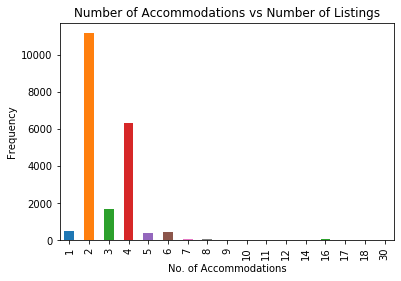

In [109]:
# Get count of listings per number of accommodations
accommodates_num_listings = df_clean.groupby('accommodates').size()
accommodates_num_listings = accommodates_num_listings.rename(columns = {'price': 'Number of Listings'})

accommodates_num_listings.plot.bar()
plt.title('Number of Accommodations vs Number of Listings')
plt.xlabel('No. of Accommodations')
plt.ylabel('Frequency')
plt.show()

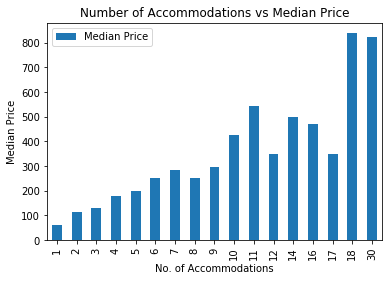

In [110]:
# Get median price of listings per number of accommodations
accommodates_price = df_clean.groupby('accommodates').median()[['price']]
accommodates_price = accommodates_price.rename(columns = {'price': 'Median Price'})

accommodates_price.plot.bar()
plt.title('Number of Accommodations vs Median Price')
plt.xlabel('No. of Accommodations')
plt.ylabel('Median Price')
plt.show()

The first plot shows that a majority of listings in this dataset could accommodate 2-4 people, which is typical for the size of a home or apartment. This makes sense, as people would most likely use Airbnb homes in small groups for vacation purposes.

The second plot shows that the price does seem to increase as the number of accommodations goes up. The most expensive properties, in terms of median price, were when the properties could house over 10 people. 

__Question:__ Do more experienced hosts charge more?

Using the `days_as_host` variable, I will see if more experienced hosts ie. those with more days as a host, charge more for their properties.

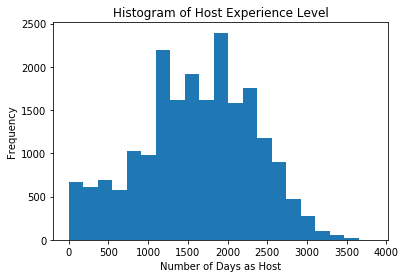

In [111]:
# Histogram of days_as_host
plt.title('Histogram of Host Experience Level')
plt.xlabel('Number of Days as Host')
plt.ylabel('Frequency')
hist_info = plt.hist(df_clean['days_as_host'], bins = np.arange(0, 3970, 365/2))
plt.show()

Each bin in the histogram above represents half a year. We see that most of the hosts have had about 1000 to 2000 days of experience ie. 2 to 5 years of experience. 

In [112]:
bin_values = hist_info[0]
bin_widths = hist_info[1]

In [113]:
# For each bin width, compute median price if days fall in that range
days_as_host_median_prices = []
days_as_host_grouping = df_clean.groupby('days_as_host').size()
for i, bin_width in enumerate(bin_widths[:-1]): # Exclude last value, will compute median later
    left_val = bin_width
    right_val = bin_widths[i + 1]
    
    median_price = df_clean[(df_clean['days_as_host'] >= left_val) & (df_clean['days_as_host'] <= right_val)]['price'].median()
    days_as_host_median_prices.append(median_price)

# Get median of properties where hosts have more than 3832 days of experience
days_as_host_median_prices.append(df_clean[df_clean['days_as_host'] >= 3832.5 ]['price'].median())

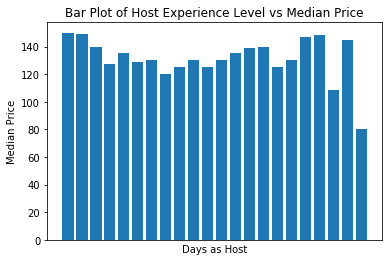

In [114]:
plt.title('Bar Plot of Host Experience Level vs Median Price')
plt.xlabel('Days as Host')
plt.ylabel('Median Price')
plt.bar(np.arange(0, len(bin_widths)), days_as_host_median_prices)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

Each bar represents a bin in from the histogram. So, the first bar shows the median price for hosts with at most half a year of experience. From the graph, we can see that hosts, across all experience levels, generally charge the same amount for their properties on Airbnb. Those with the least amount of experience charge slightly more than more experienced hosts, but some hosts with several years of experience charge as much as newcomers.

__Question:__ Do more experienced hosts have more listings?

In [115]:
# For each bin width, compute calculated number of listings if days fall in that range
days_as_host_num_listings = []
for i, bin_width in enumerate(bin_widths[:-1]): # Exclude last value, will compute later
    left_val = bin_width
    right_val = bin_widths[i + 1]

    num_listings = df_clean[(df_clean['days_as_host'] >= left_val) & (df_clean['days_as_host'] <= right_val)]['calculated_host_listings_count'].sum()
    days_as_host_num_listings.append(num_listings)

# Get median of properties where hosts have more than 3832 days of experience
days_as_host_num_listings.append(df_clean[df_clean['days_as_host'] >= 3832.5 ]['calculated_host_listings_count'].sum())

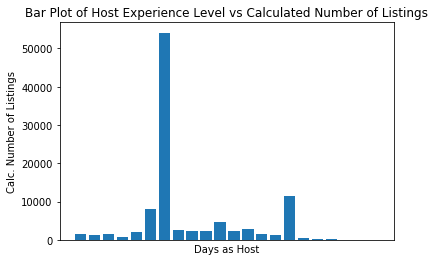

In [116]:
plt.title('Bar Plot of Host Experience Level vs Calculated Number of Listings')
plt.xlabel('Days as Host')
plt.ylabel('Calc. Number of Listings')
plt.bar(np.arange(0, len(bin_widths)), days_as_host_num_listings)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

Above is a plot of the host's experience level against the calculated number of listings. Again, each bar represents half a year worth of experience. We can see that the experience level of hosts that have the most number of listings is when they have about 2.5 to 3 years of experience.

__Question:__ Do more experienced hosts have more reviews?

In [117]:
days_as_host_num_reviews = []
for i, bin_width in enumerate(bin_widths[:-1]): 
    left_val = bin_width
    right_val = bin_widths[i + 1]

    num_reviews = df_clean[(df_clean['days_as_host'] >= left_val) & (df_clean['days_as_host'] <= right_val)]['number_of_reviews'].sum()
    days_as_host_num_reviews.append(num_reviews)

days_as_host_num_reviews.append(df_clean[df_clean['days_as_host'] >= 3832.5 ]['number_of_reviews'].sum())

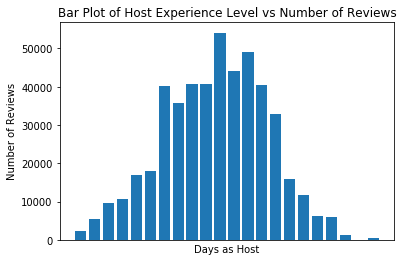

In [118]:
plt.title('Bar Plot of Host Experience Level vs Number of Reviews')
plt.xlabel('Days as Host')
plt.ylabel('Number of Reviews')
plt.bar(np.arange(0, len(bin_widths)), days_as_host_num_reviews)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])

plt.show()

Above is a plot of the host's experience level versus the number of reviews their listing got. We can see that, generally, more experience hosts get more reviews than newcomers. This makes sense, as newcomers would have just recently posted their property. Why do the most experienced hosts have less reviews? This could be due to the fact that there are not a lot of hosts with years and years of experience. Most have about a two or three years worth of experience.

### Additional Cleaning

Here I do some more cleaning. There is one variable that I should include here, which is `extra_people`, which corresponds to the amount guests must pay for extra people to come to the property. I will have to preprocess it like `security_deposit`.

In [119]:
df_clean['extra_people'] = df_clean['extra_people'].fillna('$0')
df_clean['extra_people'] = df_clean['extra_people'].apply(dollar_str_to_int)

quant_vars.append('extra_people')

### Visualizing Quantitative Relationships

Let's look at the correlations between the different quantitative variables and `price`.

In [120]:
# Tidy up quant_vars
quant_vars = [var for var in quant_vars if var not in amenity_bool_vars]
quant_vars = [var for var in quant_vars if var not in categ_bool_vars]
quant_vars = [var for var in quant_vars if var not in verification_bool_vars]
quant_vars = [var for var in quant_vars if var not in categ_vars_enc]
quant_vars.remove('market_enc')

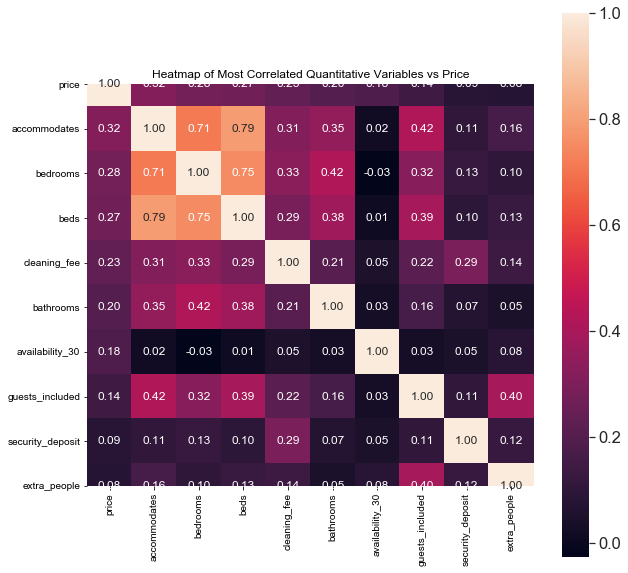

In [121]:
# Get a quick look at the correlations between the quantitative variables and price
corrmat = df_clean[quant_vars].corr()

f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Heatmap of Most Correlated Quantitative Variables vs Price')
k = 10 
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_clean[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the heatmap above, we see that of the quantitative variables, the variable most correlated with `price` is `accommodates`, which corresponds to how many guests the property can accommodate. However, this correlation is not very strong. In fact, most of the variables are not very strongly correlated with `price`. Airbnb hosts can choose how they want to price their properties, which may explain why the correlation is so small. Hosts will price their homes depending on personal opinion, unlike a real-estate agent, who price homes based on experience and the market.  

Above we also see instances of multicollinearity. Specifically, we see that `beds` is strongly correlated with `accommodates`, which makes sense given that if a property can hold more people, then it should have at least have the same amount of beds. 

For now, I will keep these variables, but if training needs to be improved, I will remove `bedrooms` and `beds`, as `accommodates` better describes these.

### Normality Checking and Encoding

Below, I log-transform non-normal quantitative variables. Note that some variables contained a 0 as a value. In order to transform these, I will create a new column to record whether or not a value exists. Then, on the nonzero values, I will log-transform them.

For example, observations with a `days_as_host` of 0 will be added to and recorded in a new boolean column capturing whether or not the person has been a host. 

In [122]:
# Holds the names of the columns that have a 0
quant_bool_vars = []

# Holds the names of the columns that have been encoded (transformed or not)
quant_vars_enc = []

for var in [bool_var for bool_var in quant_vars if 0 in df_clean[bool_var].values]:
    # Boolean encode
    df_clean['has_' + var] = df_clean[var].apply(lambda x: 1 if x > 0 else 0)
    quant_bool_vars.append('has_' + var)
    
    # Log transform
    if is_normal(df_clean[var]):
        # No need for any transforming
        quant_vars_enc.append(var)
    else:
        # Log transform, create a new column, and append the name to the list
        new_col = var + '_enc'
        df_clean[new_col] = df_clean[var].apply(lambda x: np.log(abs(x)) if x > 0 else 0)
        quant_vars_enc.append(new_col)

In [123]:
# Don't forget about accommodates!
if is_normal(df_clean['accommodates']):
    quant_vars_enc.append(var)
else:
    df_clean['accommodates_enc'] = df_clean[var].apply(lambda x: np.log(abs(x)) if x > 0 else 0)
    quant_vars_enc.append('accommodates_enc')

In [124]:
print(quant_bool_vars)
print(quant_vars_enc)

['has_bathrooms', 'has_bedrooms', 'has_beds', 'has_security_deposit', 'has_cleaning_fee', 'has_availability_30', 'has_number_of_reviews', 'has_reviews_per_month', 'has_days_since_first_review', 'has_days_since_last_review', 'has_days_as_host', 'has_extra_people']
['bathrooms_enc', 'bedrooms_enc', 'beds_enc', 'security_deposit_enc', 'cleaning_fee_enc', 'availability_30_enc', 'number_of_reviews_enc', 'reviews_per_month_enc', 'days_since_first_review_enc', 'days_since_last_review_enc', 'days_as_host_enc', 'extra_people_enc', 'accommodates_enc']


# Model Building

Below is my code for building the model to predict price. It may seem messy, but that is because I wanted to show my entire thought process. However, I generally wanted to use ensemble techniques (bagging and boosting) to try and model my data.

Overall, this was my way of really getting to understand the data, what I could potentially do to model it, and the different ways I could try to improve those models. There are lots of things I could be exploring more in-depth, but to me, I wanted to explore different methods breadth-wise rather than depth-wise.

In [125]:
# How many variables do I have for training?
training_vars = quant_bool_vars + quant_vars_enc + amenity_bool_vars + categ_bool_vars + verification_bool_vars + categ_vars_enc

model_df = df_clean[training_vars + ['log_price']]
model_df.head()

,has_bathrooms,has_bedrooms,has_beds,has_security_deposit,has_cleaning_fee,has_availability_30,has_number_of_reviews,has_reviews_per_month,has_days_since_first_review,has_days_since_last_review,...,cleaned_review_scores_rating_enc,cleaned_review_scores_accuracy_enc,cleaned_review_scores_cleanliness_enc,cleaned_review_scores_checkin_enc,cleaned_review_scores_communication_enc,cleaned_review_scores_location_enc,cleaned_review_scores_value_enc,cleaned_host_response_rate_enc,neighbourhood_cleansed_enc,log_price
0,1,1,1,1,1,1,1,1,1,1,...,6.0,3.0,6.0,3.0,3.0,6.0,3.0,4.0,8.0,4.077537
1,1,1,1,0,0,0,1,1,1,1,...,3.0,2.0,6.0,3.0,3.0,6.0,2.0,4.0,21.0,4.382027
2,1,1,1,1,1,1,1,1,1,1,...,6.0,3.0,6.0,3.0,3.0,6.0,3.0,4.0,22.0,4.828314
3,1,1,1,0,0,1,1,1,1,1,...,6.0,3.0,6.0,3.0,3.0,6.0,3.0,4.0,22.0,5.010635
4,1,1,1,0,0,1,1,1,1,1,...,6.0,3.0,6.0,3.0,3.0,6.0,3.0,4.0,22.0,4.317488


In [126]:
print('There are', model_df.shape[0], 'observations to train with and', model_df.shape[1] - 1, 'variables.')

There are 20642 observations to train with and 112 variables.


In [127]:
# Split the data 80% training, 20% testing
X = model_df[training_vars].values
y = model_df['log_price'].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

I decided to use the mean absolute error (MAE) as my error metric. This was due to the fact that there seems to be lots of outliers in my dataset. Using this as opposed to the root mean squared error would allow less penalization in my model training. Also, it is more interpretable than the root mean squared error. 

In [128]:
def compute_mae(actual, preds):
    """
    Calculates the mean absolute error between two lists of values.
    """
    return(mean_absolute_error(actual, preds))

### Simple Linear Regression Model

In [129]:
n_folds = 5

kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

train_maes = []
val_maes = []
lreg = LinearRegression()

# Perform K-Fold CV
for train_inds, val_inds in kf.split(X_train_val):
    X_train, X_val = X_train_val[train_inds], X_train_val[val_inds]
    y_train, y_val = y_train_val[train_inds], y_train_val[val_inds]
    
    lreg.fit(X_train, y_train)
    train_preds = lreg.predict(X_train)
    val_preds = lreg.predict(X_val)
    
    train_maes.append(compute_mae(y_train, train_preds))
    val_maes.append(compute_mae(y_val, val_preds))
    

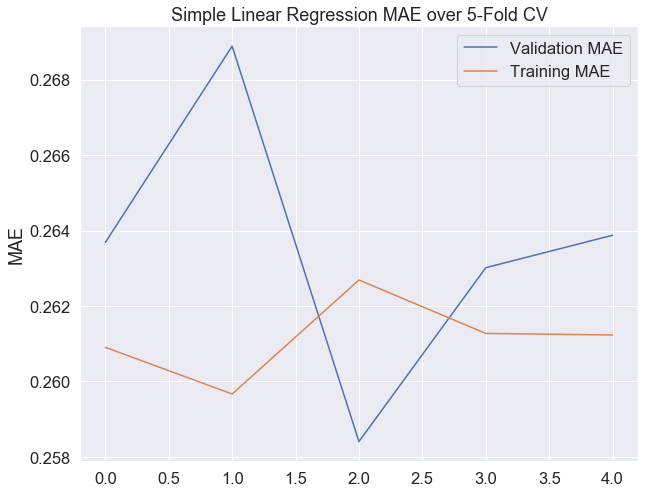

In [130]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(np.arange(0, n_folds), val_maes, label = 'Validation MAE')
plt.plot(np.arange(0, n_folds), train_maes, label = 'Training MAE')
plt.ylabel('MAE')
plt.title('Simple Linear Regression MAE over 5-Fold CV')
plt.legend()
plt.show()

In [131]:
print('Best MAE:', val_maes[np.argmax(val_maes)])

Best MAE: 0.2688881434109034


We can see that there is some variability in the dataset, shown by the strong variation of the validation MAE. While the training MAE is stagnant, the validation MAE varies much more, suggesting overfitting and high variance. In order to combat this, I will use ensemble techniques, specifically boosting and bagging techniques, and see how well that does.

In [132]:
n_iters = 50
n_estimators = np.arange(10, 100, 10)
early_stopping_rounds = 15
eval_set = (X_test, y_test)
eval_metric = 'mae'

### LGBM

In [133]:
lgb_fit_dict = {
    'eval_metric': eval_metric,
    "early_stopping_rounds": early_stopping_rounds,
    "eval_set": [eval_set],
    'verbose': 100
}

lgb_param_dict = {
    'n_estimators': n_estimators,
    'num_leaves': stats.randint(6, 50), 
    'learning_rate': [0.05, 0.1, 0.3],
    'min_child_samples': stats.randint(100, 500), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': stats.uniform(loc=0.2, scale=0.8), 
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}
lgb_model = lgb.LGBMRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(lgb_model, random_state = 42, param_distributions = lgb_param_dict, 
                            n_iter = n_iters, cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

In [134]:
# Only train if there does not exist a saved model
lgb_saved_model = 'best_models/best_lgb_model.pickle.dat'

if path.exists(lgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    best_lgb_model = pickle.load(open(lgb_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    best_lgb_preds = best_lgb_model.predict(X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_lgb_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(X_train_val, y_train_val, **lgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    lgb_best_params = rs_clf.best_params_
    
    # Train using best params
    best_lgb_model = lgb.LGBMRegressor(**rs_clf.best_params_, seed = 42)
    start = time.time()
    best_lgb_model.fit(X_train_val, y_train_val)
    
    # Get MAE
    best_lgb_preds = best_lgb_model.predict(X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_lgb_preds))
    
    # Save best lgb model
    pickle.dump(best_lgb_model, open(lgb_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2527


Above I trained a LGBMRegressor on the data using 5 fold cross-validation via sklearn's RandomizedSearchCV function.

The best model was able to achieve an MAE of 0.2527, which is slightly better than the linear regression model.

### XGBoost

In [135]:
xgb_fit_dict = {
    'eval_metric': eval_metric,
    "early_stopping_rounds": early_stopping_rounds,
    "eval_set": [eval_set],
    'verbose': 100
}

xgb_param_dict = {
    'n_estimators': n_estimators,
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': stats.uniform(loc=0.2, scale=0.8),
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'gamma': [0.0, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'min_child_samples': stats.randint(100, 500), 
    "objective": ["reg:squarederror"],
    'alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

xgb_model = XGBRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = n_iters, 
                            cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

In [136]:
# Only train if there does not exist a saved model
xgb_saved_model = 'best_models/best_xgb_model.pickle.dat'

if path.exists(xgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    best_xgb_model = pickle.load(open(xgb_saved_model, 'rb'))
    
    print('Saved Model Parameters')
    print(best_xgb_model.get_xgb_params())
    
    # Compute saved model's RMSE
    best_xgb_preds = best_xgb_model.predict(X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_xgb_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(X_train_val, y_train_val, **xgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    xgb_best_params = rs_clf.best_params_
    
    # Train using best params
    best_xgb_model = XGBRegressor(**xgb_best_params, seed = 42)
    start = time.time()
    best_xgb_model.fit(X_train_val, y_train_val)
    
    # Get MAE
    best_xgb_preds = best_xgb_model.predict(X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(best_xgb_model, open(xgb_saved_model, 'wb'))

I already have a saved model.
Saved Model Parameters
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6569886849640647, 'gamma': 0.0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0.001, 'missing': nan, 'n_estimators': 60, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.77167673816005, 'verbosity': 1, 'alpha': 10, 'lambda': 0, 'min_child_samples': 100}
Model took 0.00 seconds to complete.
MAE: 0.2501


Above I used XGBoost to model the data. This helped me achieve an MAE of 0.2501, which is slightly better than the previous LGBMRegressor.

### GradientBoosting

In [137]:
gb_param_dict = {
    'n_estimators': n_estimators,
    'max_depth': [5, 7, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'loss': ['huber', 'lad'],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': stats.uniform(loc=0.2, scale=0.8),
    'min_samples_leaf': stats.randint(100, 500)
}

gb_model = GradientBoostingRegressor(random_state = 42, n_iter_no_change = early_stopping_rounds, tol = 0.1)

rs_clf = RandomizedSearchCV(gb_model, random_state = 42, 
                            param_distributions = gb_param_dict, 
                            n_iter = n_iters, 
                            cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

In [138]:
# Only train if there does not exist a saved model
gb_saved_model = 'best_models/best_gb_model.pickle.dat'

if path.exists(gb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    best_gb_model = pickle.load(open(gb_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    best_gb_preds = best_gb_model.predict(X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_gb_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(X_train_val, y_train_val)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Train using best params
    best_gb_model = GradientBoostingRegressor(**rs_clf.best_params_, random_state = 42)
    start = time.time()
    best_gb_model.fit(X_train_val, y_train_val)
    
    # Get MAE
    best_gb_preds = best_gb_model.predict(X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_gb_preds))
    
    # Save best gb model
    pickle.dump(best_gb_model, open(gb_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2517


Above I used the GradientBoostingRegressor provided by sklearn to model the data. This helped me achieve an MAE of 0.2517.

### AdaBoost

In [139]:
ab_param_dict = {
    'learning_rate': [0.05, 0.1, 0.3],
    'loss': ['linear', 'square', 'exponential'],
    'n_estimators': n_estimators
}

ab_model = AdaBoostRegressor(random_state = 42)

rs_clf = RandomizedSearchCV(ab_model, param_distributions = ab_param_dict, random_state = 42,
                            n_iter = n_iters, cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = True) 

In [140]:
# Only train if there does not exist a saved model
ab_saved_model = 'best_models/best_ab_model.pickle.dat'

if path.exists(ab_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    best_ab_model = pickle.load(open(ab_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    best_ab_preds = best_ab_model.predict(X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_ab_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(X_train_val, y_train_val)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    ab_best_params = rs_clf.best_params_
    
    # Train using best params
    best_ab_model = AdaBoostRegressor(**rs_clf.best_params_, random_state = 42)
    start = time.time()
    best_ab_model.fit(X_train_val, y_train_val)
    
    # Get MAE
    best_ab_preds = best_ab_model.predict(X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, best_ab_preds))
    
    # Save best ab model
    pickle.dump(best_ab_model, open(ab_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2991


Above I used AdaBoost, and this achieved the worst MAE of the three models.

### Bagging 

Below I simply average the predictions from each of the three models with their best respective parameters and compute the MAE from there. 

This gets a final MAE of 0.2515, which is better than our simple linear regression model from above, but not the best model so far.

In [141]:
# Aggregate average score together
best_xgb_preds = best_xgb_model.predict(X_test)
best_lgb_preds = best_lgb_model.predict(X_test)
best_gb_preds = best_gb_model.predict(X_test)
best_ab_preds = best_ab_model.predict(X_test)

bagged_preds = (best_xgb_preds + best_lgb_preds + best_ab_preds + best_gb_preds) / 4

compute_mae(y_test, bagged_preds)

0.25151311991692943

## Using Principal Components (PCs) 

I could try to improve the model by reducing the feature space of the dataset. I will do this via PCA, and reduce the feature space to 50 features, which is about half the amount of the original feature space.

In [142]:
k = 50
pca = PCA(n_components = k)
pca.fit(X)
components = pca.components_ 
proj_X = pca.fit_transform(X) 

# Projected partitions of X and y
proj_X_train_val, proj_X_test, proj_y_train_val, proj_y_test = train_test_split(proj_X, y, test_size=0.2)

### Simple Linear Regression again, with 50 PCs

In [143]:
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

train_maes = []
val_maes = []
pc_reg = LinearRegression()

# Perform K-Fold CV
for train_inds, val_inds in kf.split(X_train_val):
    X_train, X_val = proj_X_train_val[train_inds], proj_X_train_val[val_inds]
    y_train, y_val = proj_y_train_val[train_inds], proj_y_train_val[val_inds]
    
    pc_reg.fit(X_train, y_train)
    train_preds = pc_reg.predict(X_train)
    val_preds = pc_reg.predict(X_val)
    
    train_maes.append(compute_mae(y_train, train_preds))
    val_maes.append(compute_mae(y_val, val_preds))

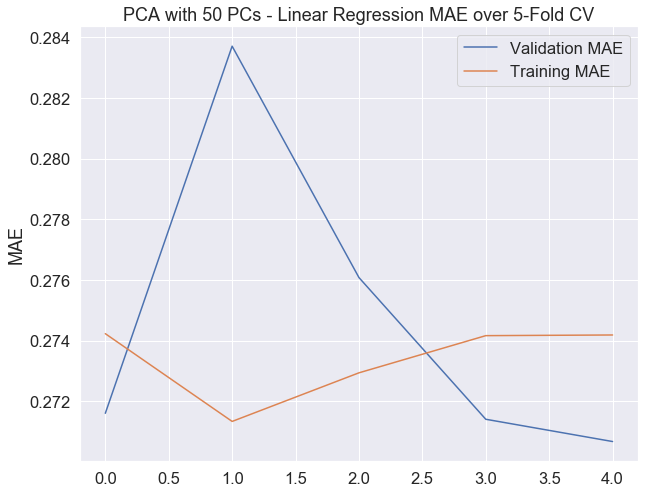

In [144]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(np.arange(0, n_folds), val_maes, label = 'Validation MAE')
plt.plot(np.arange(0, n_folds), train_maes, label = 'Training MAE')
plt.ylabel('MAE')
plt.title('PCA with 50 PCs - Linear Regression MAE over 5-Fold CV')
plt.legend()
plt.show()

In [145]:
print('Best MAE:', val_maes[np.argmax(val_maes)])

Best MAE: 0.2837112129125732


Above we can see the same problem with variability as before. However, the MAE is slightly worse than before. This may suggest that reducing the feature space may not be the best idea. When using the entire feature space, XGBoost performed the best. So, I will train that on the reduced feature space oof 50 PCs, and see how well that does. If it does considerably worse, than I will not proceed with using 50 PCs.

### XGBoost with 50 PCs

In [146]:
xgb_model = XGBRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(xgb_model, random_state = 42,
                            param_distributions = xgb_param_dict, 
                            n_iter = n_iters, 
                            cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

# Only train if there does not exist a saved model
xgb_saved_model = 'best_models_pc/best_xgb_model.pickle.dat'

if path.exists(xgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    best_xgb_model = pickle.load(open(xgb_saved_model, 'rb'))
    
    print('Saved Model Parameters')
    print(best_xgb_model.get_xgb_params())
    
    # Compute saved model's RMSE
    best_xgb_preds = best_xgb_model.predict(proj_X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(proj_y_test, best_xgb_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(proj_X_train_val, proj_y_train_val)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    xgb_best_params = rs_clf.best_params_
    
    # Train using best params
    best_xgb_model = XGBRegressor(**xgb_best_params, seed = 42)
    start = time.time()
    best_xgb_model.fit(proj_X_train_val, proj_y_train_val)
    
    # Get MAE
    best_xgb_preds = best_xgb_model.predict(proj_X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(proj_y_test, best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(best_xgb_model, open(xgb_saved_model, 'wb'))

I already have a saved model.
Saved Model Parameters
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8355734073221437, 'gamma': 0.2, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1e-05, 'missing': nan, 'n_estimators': 80, 'nthread': 1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 42, 'subsample': 0.828272520891155, 'verbosity': 1, 'alpha': 1, 'lambda': 5, 'min_child_samples': 215}
Model took 0.00 seconds to complete.
MAE: 0.2467


Above we can see the results of training an XGBoost model on 50 PCs. We see that the MAE was worse than when training using only 50 PCs by about 2%.

I do not expect that the other models trained on 50 PCs will perform any better than when trained on all the features.

Below I try to see which features are important and which aren't ie. feature selection. This is another method of reducing the feature space for training my model, and will allow me to keep the original values from my columns, unlike using the principal components. Doing this may help with improving the model, as I am reducing the feature space by eliminating the features that aren't as helpful.

In [147]:
# Get best xgboost params
fs_xgb_model = pickle.load(open('best_models/best_xgb_model.pickle.dat', 'rb'))

fs_xgb_model = XGBRegressor(params = fs_xgb_model.get_xgb_params())
fs_xgb_model.fit(X_train_val, y_train_val)

[15:20:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear',
             params={'alpha': 10, 'base_score': 0.5, 'booster': 'gbtree',
                     'colsample_bylevel':...
                     'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7,
                     'min_child_samples': 100, 'min_child_weight': 0.001,
                     'missing': nan, 'n_estimators': 60, 'nthread': 1,
                     'objective': 'reg:squarederror', 'reg_alpha': 0,
                     'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 42,
                     'subsample': 0.77167673816005, 'verbosity': 1},
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, s

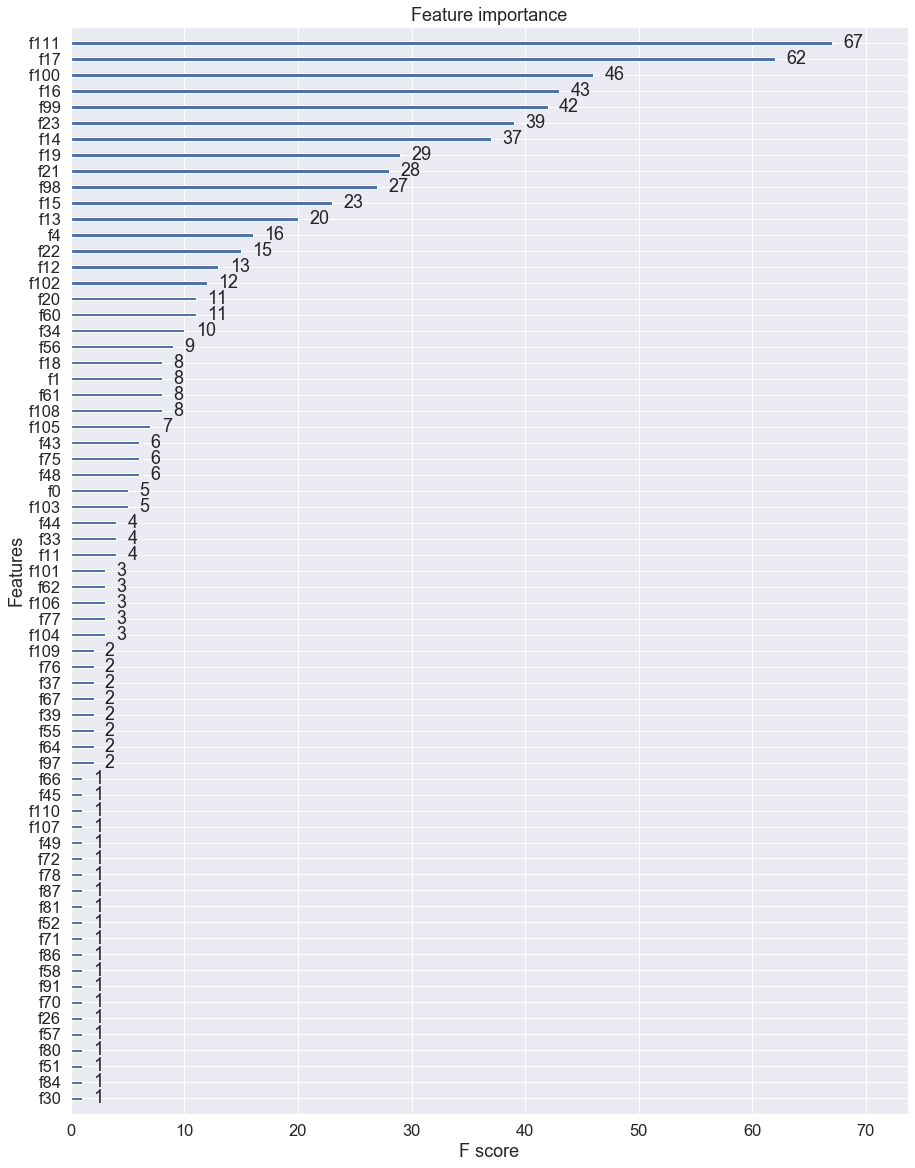

In [148]:
f, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(fs_xgb_model, ax = ax)
plt.show()

To determine feature importance, I used the best parameters learned from the 5-fold CV above, and trained an XGBoostRegressor model using those parameters on the entire training and validation set.

Above is a plot of the most important features, where the top most bar represents the most important feature. More specifically, it shows the number of times each feature is split across all boosting rounds in the model. 

Below, I try to determine which features are the most important.

__Question:__ What are the most important features?

In [149]:
print(model_df.columns[111])
print(model_df.columns[17])
print(model_df.columns[100])
print(model_df.columns[16])
print(model_df.columns[99])
print(model_df.columns[23])
print(model_df.columns[14])
print(model_df.columns[19])
print(model_df.columns[21])
print(model_df.columns[98])

neighbourhood_cleansed_enc
availability_30_enc
room_type_enc
cleaning_fee_enc
property_type_enc
extra_people_enc
beds_enc
reviews_per_month_enc
days_since_last_review_enc
host_verifications_enc


We see that, according to my model, the most important feature is the neighborhood that a listing is located in. It also seems to be that case that the number of accommodations a property can have is not that important. It is also surprising to see that the kinds of verifications a host has is important to my model.

In [150]:
thresholds = np.sort(np.unique(fs_xgb_model.feature_importances_))

In [151]:
fs_maes = [] # Holds the test MAEs
best_threshold = thresholds[0]
best_mae = float('inf')

for threshold in thresholds:
    selection = SelectFromModel(fs_xgb_model, threshold = threshold, prefit = True)
    selection_X_train_val = selection.transform(X_train_val)
    
    # Train model on training/val set
    selection_model = XGBRegressor(random_state = 42, params = fs_xgb_model.get_xgb_params(), objective = 'reg:squarederror')
    selection_model.fit(selection_X_train_val, y_train_val)
    
    # Evaluate on the test set
    selection_X_test = selection.transform(X_test)
    selection_y_pred = selection_model.predict(selection_X_test)
    
    test_mae = compute_mae(y_test, selection_y_pred)
    fs_maes.append(test_mae)
    
    print("Threshold = %.3f, n = %d, MAE: %.5f" % (threshold, selection_X_train_val.shape[1], test_mae))
    
    # Get the best threshold depending on the test_mae
    if test_mae < best_mae:
        best_mae = test_mae
        best_threshold = threshold
    

Threshold = 0.000, n = 112, MAE: 0.25531
Threshold = 0.000, n = 67, MAE: 0.25531
Threshold = 0.001, n = 66, MAE: 0.25531
Threshold = 0.001, n = 65, MAE: 0.25524
Threshold = 0.001, n = 64, MAE: 0.25524
Threshold = 0.002, n = 63, MAE: 0.25523
Threshold = 0.002, n = 62, MAE: 0.25510
Threshold = 0.002, n = 61, MAE: 0.25512
Threshold = 0.002, n = 60, MAE: 0.25512
Threshold = 0.002, n = 59, MAE: 0.25526
Threshold = 0.002, n = 58, MAE: 0.25510
Threshold = 0.002, n = 57, MAE: 0.25447
Threshold = 0.002, n = 56, MAE: 0.25448
Threshold = 0.002, n = 55, MAE: 0.25448
Threshold = 0.003, n = 54, MAE: 0.25448
Threshold = 0.003, n = 53, MAE: 0.25499
Threshold = 0.003, n = 52, MAE: 0.25495
Threshold = 0.003, n = 51, MAE: 0.25486
Threshold = 0.003, n = 50, MAE: 0.25480
Threshold = 0.003, n = 49, MAE: 0.25471
Threshold = 0.003, n = 48, MAE: 0.25470
Threshold = 0.003, n = 47, MAE: 0.25489
Threshold = 0.003, n = 46, MAE: 0.25489
Threshold = 0.003, n = 45, MAE: 0.25508
Threshold = 0.004, n = 44, MAE: 0.25501

In [152]:
print('Best Threshold:', best_threshold)
print('Best MAE:', fs_maes[np.argmin(fs_maes)])

Best Threshold: 0.0047210823
Best MAE: 0.2544592373219205


In [153]:
selection = SelectFromModel(fs_xgb_model, threshold = best_threshold, prefit = True)
selection_X_train_val = selection.transform(X_train_val)

selection_model = XGBRegressor(random_state = 42, 
                               params = fs_xgb_model.get_xgb_params(), 
                               objective = 'reg:squarederror')
selection_model.fit(selection_X_train_val, y_train_val)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             params={'base_score': 0.5, 'booster': 'gbtree',
                     'colsample_bylevel': 1, 'co...
                                'n_estimators': 60, 'nthread': 1,
                                'objective': 'reg:squarederror', 'reg_alpha': 0,
                                'reg_lambda': 1, 'scale_pos_weight': 1,
                                'seed': 42, 'subsample': 0.77167673816005,
                                'verbosity': 1},
                     'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1,
                     'seed': 0, 'subsample': 1, 'verbosity': 1},
             random_state=42, reg_alpha=0, reg_lambda

In [154]:
# Save best selection model
pickle.dump(selection_model, open('fs_model.pickle.dat', 'wb'))

Above are the different MAEs given different number of features based on their importance. For example, the very last line shows that the only feature used was the top most feature. The model used this sole feature, and was trained on the entire training and validation set. Finally, the test MAE was calculated, which was 0.33822. 

We can see that there is lots of stagnation at a MAE of around 0.25. The XGBoostRegressor performs its best when there are around 50-60 variables, achieving an MAE of around 0.254. There was not a lot of improvement, though I may try to explore this method more in the future given that it performs almost as well as the previous models that were trained on the entire feature space.

Instead, I could try using deep-learning techniques, such as a neural network.
Below is a 4 layer neural network with regularization.

## Deep Learning

In [155]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from tensorflow import set_random_seed

Using TensorFlow backend.


In [156]:
set_random_seed(42)

nn = models.Sequential()
nn.add(layers.Dense(128, input_shape=(X_train_val.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn.compile(loss='mae',
            optimizer='adam',
            metrics=['mae'])

# Model summary
print(nn.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               14464     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 245,377
Trainable params: 245,377
Non-trainable params: 0
_________________________________________________________________
None


In [157]:
# Training the model
nn.fit(X, y, epochs = 150, batch_size = 256, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 16513 samples, validate on 4129 samples
Epoch 1/150
16513/16513 [==============================] - 1s 42us/step - loss: 41.5301 - mae: 1.5449 - val_loss: 22.5219 - val_mae: 0.4313
Epoch 2/150
16513/16513 [==============================] - 0s 27us/step - loss: 15.8236 - mae: 0.3849 - val_loss: 12.2889 - val_mae: 0.5583
Epoch 3/150
16513/16513 [==============================] - 0s 27us/step - loss: 10.6216 - mae: 0.3624 - val_loss: 9.4362 - val_mae: 0.4125
Epoch 4/150
16513/16513 [==============================] - 0s 27us/step - loss: 8.4956 - mae: 0.3687 - val_loss: 7.7259 - val_mae: 0.4411
Epoch 5/150
16513/16513 [==============================] - 0s 27us/step - loss: 7.0157 - mae: 0.3935 - val_loss: 6.3854 - val_mae: 0.3974
Epoch 6/150
16513/16513 [==============================] - 0s 27us/step - loss: 5.8339 - mae: 0.3571 - val_loss: 5.4179 - val_mae: 0.4330
Epoch 7/150
16513/16513 [==============================] - 0s 27us/ste

Epoch 58/150
16513/16513 [==============================] - 0s 27us/step - loss: 0.5071 - mae: 0.2773 - val_loss: 0.5705 - val_mae: 0.3421
Epoch 59/150
16513/16513 [==============================] - 0s 27us/step - loss: 0.5023 - mae: 0.2746 - val_loss: 0.5549 - val_mae: 0.3283
Epoch 60/150
16513/16513 [==============================] - 0s 29us/step - loss: 0.5008 - mae: 0.2750 - val_loss: 0.5820 - val_mae: 0.3571
Epoch 61/150
16513/16513 [==============================] - 0s 28us/step - loss: 0.5029 - mae: 0.2786 - val_loss: 0.5650 - val_mae: 0.3424
Epoch 62/150
16513/16513 [==============================] - 0s 29us/step - loss: 0.4966 - mae: 0.2744 - val_loss: 0.5610 - val_mae: 0.3408
Epoch 63/150
16513/16513 [==============================] - 0s 27us/step - loss: 0.4937 - mae: 0.2735 - val_loss: 0.5459 - val_mae: 0.3261
Epoch 64/150
16513/16513 [==============================] - 0s 29us/step - loss: 0.4955 - mae: 0.2767 - val_loss: 0.5472 - val_mae: 0.3297
Epoch 65/150
16513/16513 [=

Epoch 117/150
16513/16513 [==============================] - 0s 26us/step - loss: 0.4498 - mae: 0.2635 - val_loss: 0.5288 - val_mae: 0.3425
Epoch 118/150
16513/16513 [==============================] - 0s 28us/step - loss: 0.4516 - mae: 0.2653 - val_loss: 0.5051 - val_mae: 0.3186
Epoch 119/150
16513/16513 [==============================] - 0s 28us/step - loss: 0.4516 - mae: 0.2654 - val_loss: 0.5130 - val_mae: 0.3270
Epoch 120/150
16513/16513 [==============================] - 0s 28us/step - loss: 0.4506 - mae: 0.2645 - val_loss: 0.5047 - val_mae: 0.3184
Epoch 121/150
16513/16513 [==============================] - 0s 28us/step - loss: 0.4515 - mae: 0.2653 - val_loss: 0.5188 - val_mae: 0.3327
Epoch 122/150
16513/16513 [==============================] - 0s 29us/step - loss: 0.4488 - mae: 0.2630 - val_loss: 0.5062 - val_mae: 0.3208
Epoch 123/150
16513/16513 [==============================] - 0s 30us/step - loss: 0.4493 - mae: 0.2635 - val_loss: 0.5047 - val_mae: 0.3184
Epoch 124/150
16513/

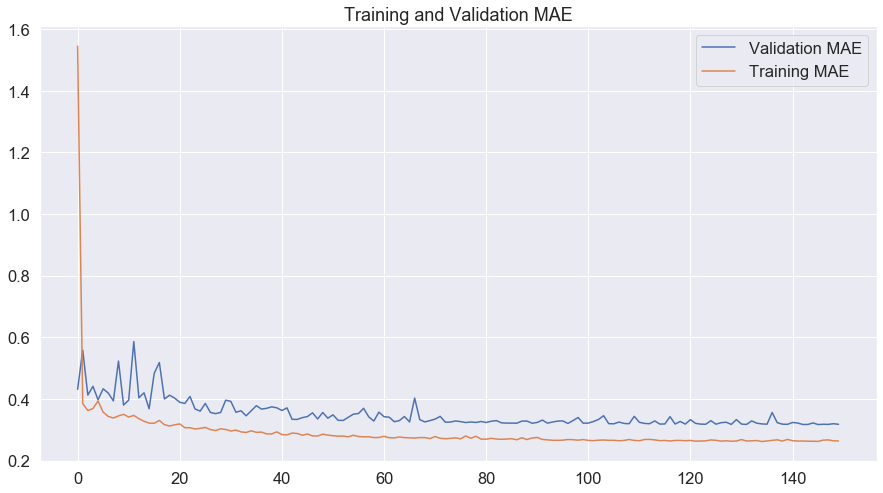

In [158]:
# Plot MAE
model_results = nn.history.history

f, ax = plt.subplots(figsize=(15,8))

plt.plot(model_results['val_mae'], label = 'Validation MAE')
plt.plot(model_results['mae'], label = 'Training MAE')

plt.title('Training and Validation MAE')

plt.legend()

plt.show()

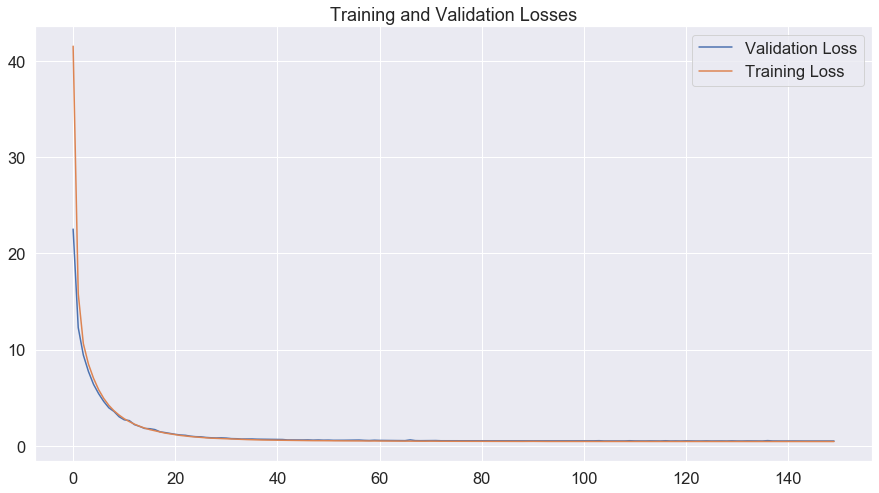

In [159]:
f, ax = plt.subplots(figsize=(15,8))

plt.plot(model_results['val_loss'], label = 'Validation Loss')
plt.plot(model_results['loss'], label = 'Training Loss')

plt.title('Training and Validation Losses')

plt.legend()

plt.show()

In [160]:
print('Testing MAE for Neural Network:', compute_mae(y_test, nn.predict(X_test)))

Testing MAE for Neural Network: 0.27177164196697107


In [161]:
# Save neural network
pickle.dump(nn, open('nn.pickle.dat', 'wb'))

Above we see that although the neural network was able to handle the variability and was able to somewhat lessen the degree of overfitting, it still does not do that well on the test set.

## Results so far

So far, here is a table of the results of the different models and their MAE on the test set:


| __Model__ 	| __Test MAE__ 	|
|:---------------------------------------------------------------	|--------------:	|
| Linear Regression w/out PCs 	| 0.2688 	|
| XGBoost w/out PCs 	| 0.2501 	|
| LGBM w/out PCS 	| 0.2527 	|
| GradientBoosting w/out PCs 	| 0.2517 	|
| AdaBoost w/out PCs 	| 0.2991 	|
| Averaging XGBoost, LGBM, GradientBoosting, AdaBoost w/out PCs 	| 0.2515 	|
| Linear Regression w/ PCs 	| 0.2764 	|
| XGBoost w/ PCs 	| 0.2738 	|
| XGBoost w/ Feature Selection (Best Threshold) 	| 0.2544 	|
| 4 Layer Neural Network w/ L1 Regularization 	| 0.2718 	|


Though the XGBoost without PCs worked the best, it was quite similar to GradientBoosting without PCs, LGBM without PCs, the averaging model, and the feature selection XGBoost model.

Performing feature selection did not improve the model that much, especially when using the best hyperparameters found earlier. Exploring this further may be helpful for improving the model because the reduced feature space may speed up training time, but for now, I want to explore other avenues that could also potentially improve our original models. 

These other avenues include dropping `bedrooms` since it is strongly correlated with `accommodates`. I keep `beds` because according to my feature selection graph above, it was more important. I will also ordinally encode `accommodates`, since it is more appropriate to consider it as a categorical variable than a quantitative one and it was the most correlated with `price`. Ordinal encoding will be similar to how I did ordinal encoding on the other categorical features. 

In [162]:
# Drop them from training variables list
training_vars.remove('bedrooms_enc')
training_vars.remove('has_bedrooms')

model_df.drop(['bedrooms_enc', 'has_bedrooms', 'accommodates_enc'], axis = 1, inplace = True)

In [163]:
# Ordinally encode accommodates
df_clean['accommodates'] = df_clean['accommodates'].apply(str)
encode(df_clean, 'accommodates')
categ_vars_enc.append('accommodates_enc')

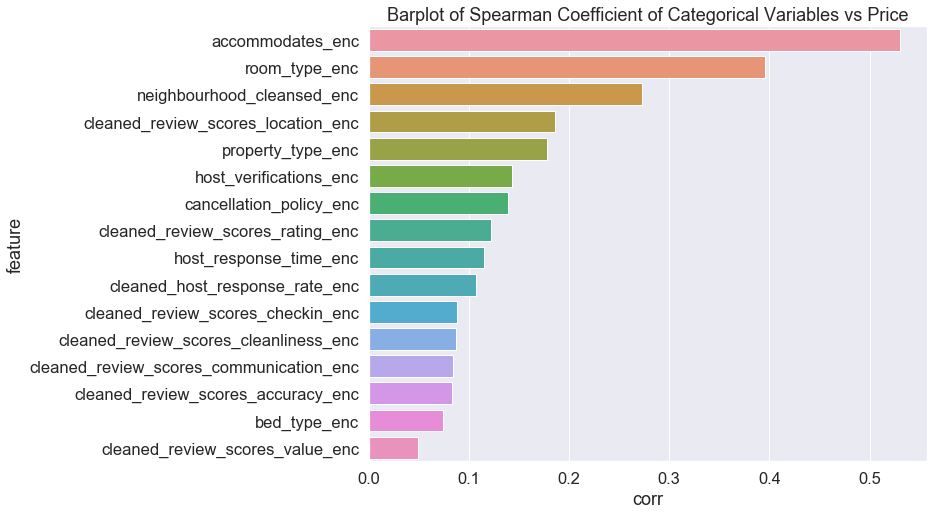

In [164]:
# Visualize
visualize_categorical_corr(df_clean, categ_vars_enc)

We see above that `accommodates_enc` is the most heavily correlated with `price`, even more than `room_type`. It also has a stronger correlation with `price` when considered this way, even more than when it was encoded as a quantitative variable. This suggests that it may be more valuable as an ordinally encoded variable than as a quantitative variable.

In [165]:
model_df['accommodates_enc'] = df_clean['accommodates_enc']

In [166]:
newX = model_df[training_vars].values
newY = model_df['log_price'].values
newX_train_val, newX_test, newY_train_val, newY_test = train_test_split(newX, newY, test_size = 0.2, random_state = 42)

In [167]:
# XGBoost
xgb_model = XGBRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = n_iters, 
                            cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

In [169]:
new_xgb_saved_model = 'best_models/new_best_xgb_model.pickle.dat'

if path.exists(new_xgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    new_best_xgb_model = pickle.load(open(new_xgb_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    new_best_xgb_preds = new_best_xgb_model.predict(newX_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_xgb_preds))
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(newX_train_val, newY_train_val)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Train using best params
    new_best_xgb_model = XGBRegressor(**rs_clf.best_params_, random_state = 42)
    start = time.time()
    new_best_xgb_model.fit(newX_train_val, newY_train_val)
    
    # Get MAE
    new_best_xgb_preds = new_best_xgb_model.predict(X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(y_test, new_best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(new_best_xgb_model, open(new_xgb_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2429


We see above that an XGBoost model performs slightly better when I preprocessed the data by dropping the `bedrooms` and ordinally encoding `accommodates`. 

Let's explore this further and use other models.

## Modelling Newly Encoded Data

For now, let's see how well my bagging technique works for this new, encoded dataset. First, I will have to create a new model for each of the boosting methods, just like I did with the XGBoost model.

In [170]:
# GradientBoosting
gb_model = GradientBoostingRegressor(random_state = 42, n_iter_no_change = early_stopping_rounds, tol = 0.1)

rs_clf = RandomizedSearchCV(gb_model, random_state = 42, 
                            param_distributions = gb_param_dict, 
                            n_iter = n_iters, 
                            cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

# Only train if there does not exist a saved model
new_gb_saved_model = 'best_models/new_best_gb_model.pickle.dat'

if path.exists(new_gb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    new_best_gb_model = pickle.load(open(new_gb_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    new_best_gb_preds = new_best_gb_model.predict(newX_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_gb_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(newX_train_val, newY_train_val)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Train using best params
    new_best_gb_model = GradientBoostingRegressor(**rs_clf.best_params_, random_state = 42)
    start = time.time()
    new_best_gb_model.fit(newX_train_val, newY_train_val)
    
    # Get MAE
    new_best_gb_preds = new_best_gb_model.predict(newX_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_gb_preds))
    
    # Save best gb model
    pickle.dump(new_best_gb_model, open(new_gb_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2472


In [171]:
# LGBM

lgb_model = lgb.LGBMRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(lgb_model, random_state = 42, param_distributions = lgb_param_dict, 
                            n_iter = n_iters, cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

# Only train if there does not exist a saved model
new_lgb_saved_model = 'best_models/new_best_lgb_model.pickle.dat'

if path.exists(new_lgb_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    new_best_lgb_model = pickle.load(open(new_lgb_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    new_best_lgb_preds = new_best_lgb_model.predict(newX_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_lgb_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(newX_train_val, newY_train_val, **lgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Train using best params
    new_best_lgb_model = lgb.LGBMRegressor(**rs_clf.best_params_, seed = 42)
    start = time.time()
    new_best_lgb_model.fit(newX_train_val, newY_train_val)
    
    # Get MAE
    new_best_lgb_preds = new_best_lgb_model.predict(newX_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_lgb_preds))
    # Save best lgb model
    pickle.dump(new_best_lgb_model, open(new_lgb_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2483


In [172]:
# AdaBoost
ab_model = AdaBoostRegressor(random_state = 42)

rs_clf = RandomizedSearchCV(ab_model, param_distributions = ab_param_dict, random_state = 42,
                            n_iter = n_iters, cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = True) 

# Only train if there does not exist a saved model
new_ab_saved_model = 'best_models/new_best_ab_model.pickle.dat'

if path.exists(new_ab_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    new_best_ab_model = pickle.load(open(new_ab_saved_model, 'rb'))
    
    # Compute saved model's RMSE
    new_best_ab_preds = new_best_ab_model.predict(newX_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_ab_preds))
    
else:
    print('Starting to train...')
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(newX_train_val, newY_train_val)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Train using best params
    new_best_ab_model = AdaBoostRegressor(**rs_clf.best_params_, random_state = 42)
    start = time.time()
    new_best_ab_model.fit(newX_train_val, newY_train_val)
    
    # Get MAE
    new_best_ab_preds = new_best_ab_model.predict(newX_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MAE: %.4f" % compute_mae(newY_test, new_best_ab_preds))
    
    # Save best ab model
    pickle.dump(new_best_ab_model, open(new_ab_saved_model, 'wb'))

I already have a saved model.
Model took 0.00 seconds to complete.
MAE: 0.2987


In [173]:
# Aggregate average score together
new_best_xgb_preds = new_best_xgb_model.predict(newX_test)
new_best_lgb_preds = new_best_lgb_model.predict(newX_test)
new_best_gb_preds = new_best_gb_model.predict(newX_test)
new_best_ab_preds = new_best_ab_model.predict(newX_test)

new_bagged_preds = (new_best_xgb_preds + new_best_lgb_preds + new_best_ab_preds + new_best_gb_preds) / 4

compute_mae(newY_test, new_bagged_preds)

0.24673677407893718

# Conclusion & More Stuff to Consider

## Making the model suitable for hosts

Something that I also wanted to explore, and that was suggested in [this notebook](https://nbviewer.jupyter.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb#Building-a-neural-network), was to look at how I can make this model more suitable for hosts when it comes to choosing the price of their listing. This means that I would have to remove variables like `reviews` and `availability`, as these are not know to the host beforehand when it comes to choosing a price. The variables that will end up being used in this model are based on going through the property listing process for Airbnb.

In [174]:
vars_to_remove = ['has_number_of_reviews', 'has_reviews_per_month',
                  'has_days_since_first_review', 'has_days_since_last_review', 
                  'availability_30_enc', 'number_of_reviews_enc', 'reviews_per_month_enc', 'days_since_first_review_enc',
                 'days_since_last_review_enc', 'is_location_exact', 'host_response_time_enc', 'instant_bookable', 
                 'cancellation_policy_enc', 'cleaned_review_scores_rating_enc', 'cleaned_review_scores_accuracy_enc',
                 'cleaned_review_scores_cleanliness_enc', 'cleaned_review_scores_checkin_enc', 
                  'cleaned_review_scores_communication_enc', 'cleaned_review_scores_location_enc', 
                  'cleaned_review_scores_value_enc', 'cleaned_host_response_rate_enc']

In [175]:
new_model_df = model_df.drop(vars_to_remove, axis = 1)

In [176]:
new_model_df.head()

,has_bathrooms,has_beds,has_security_deposit,has_cleaning_fee,has_availability_30,has_days_as_host,has_extra_people,bathrooms_enc,beds_enc,security_deposit_enc,...,kba,weibo,sesame,host_verifications_enc,property_type_enc,room_type_enc,bed_type_enc,neighbourhood_cleansed_enc,log_price,accommodates_enc
0,1,1,1,1,1,1,1,0.405465,0.693147,5.298317,...,0.0,0.0,0.0,170.0,19.0,2.0,5.0,8.0,4.077537,2.0
1,1,1,0,0,0,1,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,170.0,23.0,2.0,5.0,21.0,4.382027,2.0
2,1,1,1,1,1,1,1,0.000000,0.000000,5.703782,...,0.0,0.0,0.0,130.0,19.0,3.0,5.0,22.0,4.828314,3.0
3,1,1,0,0,1,1,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,175.0,26.0,2.0,5.0,22.0,5.010635,2.0
4,1,1,0,0,1,1,0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,175.0,19.0,2.0,5.0,22.0,4.317488,2.0


In [177]:
new_training_vars = [var for var in training_vars if var not in vars_to_remove]

In [184]:
len(new_training_vars)

89

In [178]:
host_X = new_model_df[new_training_vars].values
host_y = new_model_df['log_price'].values

host_X_train_val, host_X_test, host_y_train_val, host_y_test = train_test_split(host_X, host_y, test_size = 0.2, random_state = 42)

### XGBoost

In [179]:
# XGBoost
xgb_model = XGBRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = n_iters, 
                            cv = n_folds, 
                            scoring = 'neg_mean_absolute_error', 
                            verbose = False) 

In [180]:
rs_clf.fit(host_X_train_val, host_y_train_val)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, metric='None',
                                          min_child_weight=1, missing=None,
                                          n_estimators=100, n_jobs=4,
                                          nthread=None, objective='reg:linear',
                                          random_stat...
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                

In [181]:
rs_clf.best_params_

{'alpha': 10,
 'colsample_bytree': 0.6569886849640647,
 'gamma': 0.0,
 'lambda': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_samples': 100,
 'min_child_weight': 0.001,
 'n_estimators': 60,
 'objective': 'reg:squarederror',
 'subsample': 0.77167673816005}

In [182]:
new_best_xgb_model = XGBRegressor(**rs_clf.best_params_, seed = 42)
new_best_xgb_model.fit(host_X_train_val, host_y_train_val)
print("MAE: %.4f" % compute_mae(host_y_test, new_best_xgb_model.predict(host_X_test)))

MAE: 0.2513


We see that this model gets a 0.2513 MAE, which is just about as well as the other models. Again, further improvements to the model could be made for this part.

## Final Model Results

| __Model__ 	| __Test MAE__ 	|
|:---------------------------------------------------------------	|--------------:	|
| Linear Regression w/out PCs 	| 0.2688 	|
| XGBoost w/out PCs 	| 0.2501 	|
| LGBM w/out PCS 	| 0.2527 	|
| GradientBoosting w/out PCs 	| 0.2517 	|
| AdaBoost w/out PCs 	| 0.2991 	|
| Averaging XGBoost, LGBM, GradientBoosting, AdaBoost w/out PCs 	| 0.2515 	|
| Linear Regression w/ PCs 	| 0.2764 	|
| XGBoost w/ PCs 	| 0.2738 	|
| XGBoost w/ Feature Selection (Best Threshold) 	| 0.2544 	|
| 4 Layer Neural Network w/ L1 Regularization 	| 0.2718 	|
| XGBoost w/out PCs on Newly Encoded Data 	| 0.2429 	|
| LGBM w/out PCS on Newly Encoded Data 	| 0.2483 	|
| GradientBoosting w/out PCs on Newly Encoded Data 	| 0.2472 	|
| AdaBoost w/out PCs on Newly Encoded Data 	| 0.2987 	|
| **Averaging XGBoost, LGBM, GradientBoosting, AdaBoost w/out PCs on Newly Encoded Data** 	| **0.2467** 	|

Given the slight increase in MAE when using my bagging technique on the newly encoded data, I will conclude that my best model for predicting Airbnb sales is bagging AdaBoost, GradientBoost, LGBM, and XGBoost together. 

## Conclusions and Further Explorations

And this concludes my project for predicting prices for Airbnb listings in Amsterdam. I started off with cleaning up the data, as well as doing preprocessing and performing EDA on the various independent variables. I have also answered some questions regarding the data. To recap, here are those questions and the answers to those questions.

### Insights

| __Question__ 	| __Answer__ 	|
|:--------------------------------------------------------------------------------------------------------------------------------------------------------	|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| When were people listing their properties? Why? What are the trends? 	| The first host joined in 2008, and the most recent host joined in 2019. There is a rise in hosts joining from 2012 to 2014, most likely due to Airbnb gaining more recognition.  Most hosts joined during the springtime, most likely to capitalize on the fact that many tourists would be visiting Amsterdam during this season.  We see that there is a decline in hosts joining after 2016, which may be due to the new restrictions on properties imposed by Airbnb. 	|
| How did guests respond to Airbnb? When did they start using Airbnb? When did they start reviewing the properties? 	| The first review occurred on March of 2009, about a year after the first host joined.  We see there was a rise in guests using Airbnb a couple years (2015 - 2017) after it was first founded. It would also seem that guests start reviewing a couple of months after their stay. More specifically, it would seem that once the spring and summer season end, they start reviewing. 	|
| How many listings in each neighborhood? What is the most expensive neighborhood? 	| Most listings are in central Amsterdam. There are less listings towards the outskirts of Amsterdam.  However, prices are relatively the same regardless of proximity towards the center of Amsterdam.  Listings on the outskirts were priced as much, if not more than, listings in central Amsterdam. Initially, I thought this was because listings on the outskirts would be due to the area being more rural and less of a cityscape. However, upon further research, I found that the city of Amsterdam was creating more houses in these outskirts in an attempt to move the citizens outwards and expand. The neighborhoods on the outskirts were artificially made, and was not rural like I had thought. The prices here may reflect the idea that hosts want to capitalize on the idea that these housing projects are newer than those in central Amsterdam, and that there is less people in these areas since it is so new. One could also interpret this as the fact that hosts want to make as much money as they can from their listings, regardless of location. 	|
| How many listings got high scores? Low scores? What's the relationship between ratings and price? 	| Most of the listings got an A+ or A rating across all rating criteria. This corresponds to ratings of greater than or equal to 90 (or 9, for certain criteria). There were few listings with negative reviews. There were also several listings missing reviews. This could be due to the listings never getting any guests, or the guests not choosing to review the listing in the first place. In terms of the median price, it would seem that regardless of the rating, the prices are the same. This could be due to ratings coming after a listing being priced. This could also be due to the fact that hosts want to make as much money as possible 	|
| How many superhosts are there? Does being a superhost get you more guests? How much do they charge? What are their ratings like? 	| A majority of the hosts in this dataset (about 17,500) are not superhosts.  Despite there being a small amount of superhosts, however, they still get a decent amount of reviews. Regardless of superhost status, hosts would price their listings the same. This could again be due to superhost status being decided after a listing is priced, or the idea that hosts want to price their properties as much as possible. As for ratings, both superhosts and normal hosts got an A+ rating most of the time.  	|
| What is the most common amenity? 	| The most common amenity relates to bed and bath essentials, such as a shower, bed, pillows, bathroom, etc. Internet is also an extremely common amenity. It would also seem that having some amenities that provide privacy (eg. a lock on the bedroom) or some sort of parking amenity are also common. 	|
| How many hosts have a profile picture? Does having a profile picture get you more guests? 	| Over 90% of the hosts in this dataset have a profile picture, and those with a profile picture get more reviews. It would seem that having a profile picture is extremely common, and thus important, for hosts.  This supports the idea that having a profile picture makes people more willing to trust you, as they know how you look like. It's the same idea with LinkedIn profile pictures. 	|
| What's the most common property type? How does property type relate to price? Ratings? 	| A majority of the listings are apartments or houses.  Regardless of property type, the median price stays the same.  Lighthouses are an exception, and have an extremely high median price. Also, I see the trend of guests leaving positive ratings for apartments and houses (the two most common property types). Guests seem to be very positive in their ratings. 	|
| Do most of the listings accommodate 2-4 people ie. the typical size of a group traveling? If a listing accommodates more people, is it more expensive? 	| Many of the listings can accommodate 2-4 people, which is the typical size of a group traveling. However, we see that as the number of people a listing can accommodate increases, so too does the price. 	|
| How experienced are these hosts? Does this relate to how much they charge? How many listings do experienced hosts have? Do they have more reviews? 	| Most of the hosts had several years of experience (ie. 2-3 years). Such hosts also have more listings, compared to less-experienced hosts. Also, these hosts have more reviews compared to other host experience levels. Regardless of host experience level, we see that hosts price their properties the same. 	|
| In our model, what are the most important features? 	| The most important seems to be the neighborhood that the listing is in. Surprisingly, it would also seem that the kinds of verifications a host has is important to my model. 	|











I also made some models to predict price. These models include various ensemble techniques such as XGBoost and GradientBoost, and bagging methods. Though that process was messier than my EDA, I took this as an opportunity to explore the data, learn more about the models I was using, and learn the model-making process breadth-wise rather than depth-wise.

Overall, all of my models achieved an MAE (mean absolute error) of around 0.25. I used this metric as opposed to the root mean squared error as to try and lessen the penalization in training due to there being a lot of outliers. Also, MAE is easier to interpret, as this value means that the average error I got from my models was around 0.25 ie. if I were to be wrong for all predictions, I would be off by about 0.25. Of course, this can be improved by looking more into how to reduce variance in my models and lessen the degree of overfitting. 

Another reason to explain my models' performance could be that my data did not have features that would have affected price, such as photos of the listing or events that were going on near the listing.

I also explored different ways I could build the model overall, including making the model more suitable for hosts, which in and of itself is its own project that I am curious to go more into.

Finally, here are some other questions and improvements I can look more into for the future:

- How has COVID-19 affected Airbnb?
- How can I make a model even more suitable to hosts?
- Can these trends be seen in other areas other than Amsterdam?
- What are the other ways to reduce variability in the dataset?

Thank you for taking the time to look through this project, and I hope that you learned about the data as much as I did. As always, I am looking for more ways to improve myself, and I am open to any feedback.